# Trying to fit to the MSSFR from TNG

In [52]:
import h5py as h5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
from astropy import constants as const
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from scipy import interpolate
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.stats import norm as NormDist


from astropy.cosmology import WMAP9, z_at_value
from astropy.cosmology import Planck18  as cosmo# Planck 2018
from astropy.cosmology import z_at_value

from astropy.table import Table, Column
import os

import matplotlib
from pylab import *
from matplotlib import ticker, cm

def Mchirp(m1, m2):
    chirp_mass = np.divide(np.power(np.multiply(m1, m2), 3./5.), np.power(np.add(m1, m2), 1./5.))
    return chirp_mass    
   
base_dir    = '/Users/lieke/surfdrive/Documents/RateMassRedshiftEvolution/'
save_loc    =  base_dir+'/plots/'
TNGlocation = '/Users/lieke/surfdrive/Documents/CompareCOMPAS/'


############################
##PLOT setttings
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font', family='serif')
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,20,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize




In [3]:
sf_a_best, sf_b_best, sf_c_best,  sf_d_best = 0.02, 1.48, 4.45, 5.90
# sf_a =0.01687063881834458, sf_b =1.4834054063851878, sf_c =4.448574027958166, sf_d =5.903964702985274

# mu0=0.025, muz=-0.048, alpha_0 = -1.767, alpha_z = alphaz_best, sigma_0=1.125, sigma_z =0.048, 
mu0_best = 0.025
muz_best= -0.048
alpha0_best = -1.767
alphaz_best = 0.0
sigma0_best=1.125
sigmaz_best =0.048

# SFR(z) Madau & Dickinson 2014 shape

In [4]:

########################################################
##
########################################################
def Madau_Dickinson2014(z, a=0.015, b=2.77, c=2.9, d=5.6):
    """
    Args:
        z             --> [list of floats] List of redshifts at which to calculate things
        a,b,c,d       --> [floats] values to determine the shape of our SFR
    
    Calculates the star-formation rate density as a function of redshift
    Based on the functional form from Madau & Dickinson 2014
    default 'Neijssel et al 2019': a=0.01, b=2.77, c=2.9,  d=4.7
    Madau & Dickinson 2014: a=0.015, b=2.7, c=2.9,  d=5.6
    Madau & Fragos 2017: a=0.01, b=2.6, c=3.2,  d=6.2

    Returns:
        SFR(z) in Msun/yr/Mpc^3
    """
    dm_dtdMpc = a * (1 + z)**b/( 1 + ( (1+z)/c )**d ) *u.Msun *u.yr**-1 *u.Mpc**-3
    return dm_dtdMpc # Msun year-1 Mpc-3 

    

    

# Get dP/dZ(z)

### New log skewed distribution

metallicity density distribution
Basically this tells us what the probability of finding a certain metallicity at a certain redshift is. 

See also eq. 17 in : https://arxiv.org/ftp/arxiv/papers/1501/1501.02344.pdf


# (log) Skew normal dist: 

PDF of the skew normal is defined as:

\begin{equation}
f(Z) = 2 \phi \left(\frac{Z - \mu}{\sigma}\right) \Phi\left(\alpha \frac{Z - \mu}{\sigma} \right)
\end{equation}

$\phi(t)$ and $\Phi(t)$ are the standard ($\sigma = 1$) normal PDF and CDF respectively:

The skew normal is a generalization of the normal distribution, that gets back to a normal distribution for $\alpha = 0$.


***
The PDF for the **log-skew-normal** are then given by just substituting the random variable Z, with ln(Z)


\begin{equation}
f(Z) = 2 \phi(\frac{ln(Z) - \mu}{\sigma}) \Phi(\alpha \frac{ln(Z) - \mu}{\sigma})
\end{equation}

or written out explicitely:

\begin{equation}
f(Z) = \frac{2}{Z \sigma \sqrt{2 \pi}} e^{\frac{-1}{2} \left(\frac{\ln(Z) - \mu}{\sigma}\right)^2} 
\int_{-\infty}^{x = \left(\alpha \frac{\ln(Z) - \mu}{\sigma} \right) } \frac{1}{\sqrt{2 \pi}} e^{\frac{-1}{2}t^2} dt
\end{equation}

or

\begin{equation}
f(Z) = \frac{2}{Z \sigma \sqrt{2 \pi}} e^{\frac{-1}{2} \left(\frac{\ln(Z) - \mu}{\sigma}\right)^2} 
\frac{1}{2} \left[ 1 + erf\left(\frac{ \left(\alpha \frac{\ln(Z) - \mu}{\sigma} \right)  }{\sqrt{2}} \right) \right]
\end{equation}


The extra $1/Z$ factors in front of the PDFs come from 
\begin{equation}
\frac{dP}{dZ} = \frac{dP}{d\ln Z} \frac{d\ln Z}{dZ} = \frac{dP}{d\ln Z} \frac{1}{Z}
\end{equation}

***

## Moments
Moments of a probability distribution: the zeroth moment is the total probability (i.e. one), the first moment is the expected value, the second central moment is the variance, the third standardized moment is the skewness, and the fourth standardized moment is the kurtosis. 

equation 23) and 24) from : https://arxiv.org/ftp/arxiv/papers/1501/1501.02344.pdf
give the mean and variance of our log-skew-normally distributed random variable Z:


\begin{equation}
E(Z) = 2 e^{\mu} e^{\sigma^2 /2} \Phi(\beta \sigma)
\end{equation}


\begin{equation}
VAR(Z) = 2 e^{2\mu} e^{\sigma^2} (e^{\sigma^1} \Phi(2 \beta \sigma)  - 2\Phi(\beta \sigma)^2)
\end{equation}


with 
\begin{equation}
\beta = \frac{\alpha}{\sqrt{1 + \alpha^2} }
\end{equation}



In [5]:
def skew_metallicity_distribution(max_redshift = 10.0,redshift_step = 0.01,
                                  mu0=0.025, muz=-0.048, sigma_0=1.125, sigma_z=0.048,
                                  alpha_0 = -1.767, alpha_z = 0, 
                                  min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                  metals = [], redsh = [],
                                  min_logZ_COMPAS = np.log(1e-4),max_logZ_COMPAS = np.log(0.03)):
    #                                mu_0=0.025, muz=-0.048, sigma_0=1.125, sigma_z=0.048,alpha = -1.767,                               
    """
    Calculate the distribution of metallicities at different redshifts using a log skew normal distribution
    the log-normal distribution is a special case of this log skew normal distribution distribution, and is retrieved by setting 
    the skewness to zero (alpha = 0). 
    Based on the method in Neijssel+19. Default values of mu0=0.035, muz=-0.23, sigma_0=0.39, sigma_z=0.0, alpha =0.0, 
    retrieve the dP/dZ distribution used in Neijssel+19

    NOTE: This assumes that metallicities in COMPAS are drawn from a flat in log distribution!

    Args:
        max_redshift       --> [float]          max redshift for calculation
        redshift_step      --> [float]          step used in redshift calculation
        min_logZ_COMPAS    --> [float]          Minimum logZ value that COMPAS samples
        max_logZ_COMPAS    --> [float]          Maximum logZ value that COMPAS samples
        
        mu0    = 0.025    --> [float]           location (mean in normal) at redshift 0
        muz    = -0.05    --> [float]           redshift scaling/evolution of the location
        sigma_0 = 1.25     --> [float]          Scale (variance in normal) at redshift 0
        sigma_z = 0.05     --> [float]          redshift scaling of the scale (variance in normal)
        alpha   = -1.77    --> [float]          shape (skewness, alpha = 0 retrieves normal dist)

        min_logZ           --> [float]          Minimum logZ at which to calculate dPdlogZ (influences normalization)
        max_logZ           --> [float]          Maximum logZ at which to calculate dPdlogZ (influences normalization)
        step_logZ          --> [float]          Size of logZ steps to take in finding a Z range

    Returns:
        dPdlogZ            --> [2D float array] Probability of getting a particular logZ at a certain redshift
        metallicities      --> [list of floats] Metallicities at which dPdlogZ is evaluated
        p_draw_metallicity --> float            Probability of drawing a certain metallicity in COMPAS (float because assuming uniform)
    """
    import scipy

    ##################################
    # the PDF of a standard normal distrtibution
    def normal_PDF(x):
        return 1./(np.sqrt(2* np.pi)) * np.exp(-(1./2) * (x)**2 )

    ##################################
    # the CDF of a standard normal distrtibution
    def normal_CDF(x):
        return 1./2. * (1 + scipy.special.erf(x/np.sqrt(2)) )
    
    ##################################
    if len(redsh) == 0:
        # Make redshifts
        redshifts = np.arange(0, max_redshift + redshift_step, redshift_step)
    else:
        redshifts = redsh
        
    ##################################
    # Experiment with redshift dependence sigma
    # LOG-LINEAR
    sigma = sigma_0*10**(sigma_z*redshifts)
    #  LINEAR   sigma = sigma_z*redshifts + sigma_0
    
        ##################################
    # Experiment with redshift dependent alpha
    # LINEAR
#     alpha = alpha_0 + (alpha_z*redshifts)
    # LOG-LINEAR (better)
    alpha = alpha_0*10**(alpha_z*redshifts)
    
    ##################################
    # Follow Langer & Norman 2007? in assuming that mean metallicities evolve in z as:
    mean_metallicities = mu0 * 10**(muz * redshifts) 
    #print('np.shape(mean_metallicities)', np.shape(mean_metallicities))
        
    # Now we re-write the expected value of ou log-skew-normal to retrieve mu
    beta = alpha/(np.sqrt(1 + (alpha)**2))
    PHI  = normal_CDF(beta * sigma) # phi is now sigma x alpha dimentional 
    mu_metallicities = np.log(mean_metallicities/(2.*PHI) * 1./(np.exp(0.5*sigma**2) )  ) 

    ##################################
    if len(metals) == 0:
        # create a range of metallicities (thex-values, or raandom variables)
        log_metallicities = np.arange(min_logZ, max_logZ + step_logZ, step_logZ)
        metallicities = np.exp(log_metallicities)
    else: 
        #use a pre-determined array of metals
        metallicities     = metals
        log_metallicities = np.log(metallicities)
        step_logZ         = np.diff(log_metallicities)
        step_logZ         = step_logZ[0]
        #print('step_logZ', step_logZ)
        
    ##################################
    # probabilities of log-skew-normal (without the factor of 1/Z since this is dp/dlogZ not dp/dZ)
    dPdlogZ = 2./(sigma[:,np.newaxis]) * normal_PDF((log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis]) * normal_CDF(alpha[:,np.newaxis] * (log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis] )

    ##################################
    # normalise the distribution over al metallicities
    norm = dPdlogZ.sum(axis=-1) #* step_logZ << Fit does not converge if you multiply by step_logZ
    dPdlogZ = dPdlogZ /norm[:,np.newaxis]

    ##################################
    # assume a flat in log distribution in metallicity to find probability of drawing Z in COMPAS
    p_draw_metallicity = 1 / (max_logZ_COMPAS - min_logZ_COMPAS)
    
    return dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity




# First read the TNG data 
## And convert it to a SFDR in Msun/yr/Mpc^-3



In [6]:

######################################
# read TNG data
######################################
with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
    MetalBins     = f["MetalBins"][:]
    Lookbacktimes = f["Lookbacktimes"][:]
    BoxSfr        = f["Sfr"][:]
# Convert SFR from sfr/box to sfr Mpc-3
littleh  = 0.6774
Rbox     = 75/littleh
TNG_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
TNG_SFRD = TNG_SFRD.value

##########################################
# "observed" TNG metallicities that we use for our calculations
##########################################
center_Zbin = (MetalBins[:-1] + MetalBins[1:])/2.
# Let's not use ALL metallicities in the TNG.. (they go waay too low!)
low_bound_Z_ind = np.where(center_Zbin > 1e-5)[0]# index of center_Zbin, where Z > 1e-5
# Let's not use ALL metallicities in the TNG.. (they go waay too low!)
bound_Z_ind = np.where(np.logical_and(center_Zbin > 1e-5, center_Zbin < 50*0.014))[0]# index of center_Zbin, where Z < 50 Zsun
tofit_TNG_metals = center_Zbin[bound_Z_ind]   


##########################################
# "obesrved" SFRD in TNG
##########################################
# flip redshifts around so they are in increasing order
TNG_SFRD_inc_z = TNG_SFRD[::-1, :]
# tofit_TNG_SFRD = TNG_SFRD_inc_z[:,low_bound_Z_ind] 
tofit_TNG_SFRD = TNG_SFRD_inc_z[:,bound_Z_ind] 


##########################################
# The redshifts at which we will calc the log-skew-normal
##########################################
#### TNG redshifts corresponding to these lookback times ### 
# the last value of Lookbacktimes = 0, which is problematic for z calculation
redshifts_TNG = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in Lookbacktimes[:-1]] 
redshifts_TNG.append(0) # put redshift zero back at the end
redshifts_TNG = np.array(redshifts_TNG)
print('redshifts_TNG')  
print(['%.2f'% (z_fl) for  z_fl in redshifts_TNG[::-1] ] )
# print(np.diff(redshifts_TNG[::-1]), min(np.diff(redshifts_TNG[::-1])), max(np.diff(redshifts_TNG[::-1])))
    
reverse_lookback = Lookbacktimes[::-1]
# print('Reverse_lookback time: ')
# print(['%.2f'% (t_l) for  t_l in reverse_lookback ] )
# print(np.diff(reverse_lookback), min(np.diff(reverse_lookback)), max(np.diff(reverse_lookback)))


redshifts_TNG
['0.00', '0.01', '0.02', '0.03', '0.05', '0.06', '0.07', '0.08', '0.10', '0.11', '0.13', '0.14', '0.15', '0.17', '0.18', '0.20', '0.21', '0.23', '0.24', '0.26', '0.27', '0.30', '0.31', '0.33', '0.35', '0.36', '0.38', '0.40', '0.42', '0.44', '0.46', '0.48', '0.50', '0.52', '0.55', '0.58', '0.60', '0.62', '0.65', '0.68', '0.70', '0.73', '0.76', '0.79', '0.82', '0.85', '0.89', '0.92', '0.95', '1.00', '1.04', '1.08', '1.12', '1.16', '1.21', '1.25', '1.31', '1.36', '1.42', '1.50', '1.54', '1.61', '1.67', '1.75', '1.83', '1.91', '2.01', '2.11', '2.22', '2.33', '2.46', '2.59', '2.75', '2.91', '3.03', '3.31', '3.52', '3.74', '4.05', '4.22', '4.48', '4.72', '5.06', '5.30', '5.61', '5.94', '6.11', '6.62', '7.15', '7.40', '7.78', '8.22', '8.68', '9.28', '9.69', '10.35', '11.42', '12.53', '15.96', '22.11']


# Interpolate the TNG data

Using scipy interpolate
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html

f = interpolate.interp2d(x, y, z)



In [7]:

#########################################
x = Lookbacktimes[::-1] #redshifts_TNG[::-1]
y = tofit_TNG_metals
z = tofit_TNG_SFRD 
print('np.shape(x), np.shape(y), np.shape(z)', np.shape(x), np.shape(y), np.shape(z))

f_interp = interpolate.interp2d(x, y, z.T, kind='cubic')

# lets interpolate at regular redshift intervals
z_new    = np.arange(0, 10.1, 0.05)                       # new redshifts
xnew     = [cosmo.lookback_time(z).value for z in z_new]  # corresp lookback times
ynew     = tofit_TNG_metals ##np.logspace(-5., -0.5, 100) # new metals

SFRDnew = f_interp(xnew,ynew)

print('np.shape(xnew)', np.shape(xnew),'np.shape(ynew)', np.shape(ynew), 'np.shape(SFRDnew)', np.shape(SFRDnew) )


np.shape(x), np.shape(y), np.shape(z) (100,) (29,) (100, 29)
np.shape(xnew) (202,) np.shape(ynew) (29,) np.shape(SFRDnew) (29, 202)


# Lets start calcuatiing chi^2

In [8]:

##################################################
# muz =-0.09, mu0 =0.026, sigma =1.9, alpha=-3.3
##################################################
def calc_chi_square(fit_metals, Redshifts = redshifts_TNG[::-1],  observed_SFRD = tofit_TNG_SFRD,
                    mu_0_list = 0.026, muz_list =-0.09, sigma0_list = 1.9, sigmaz_list = 1.9, 
                    alpha0_list =-3.3, alphaz_list = 0, returnResiduals = False,
                    sf_a =0.01 , sf_b=2.6, sf_c=3.2 , sf_d=6.2, normed = False):
    """
    Calculate the distribution of metallicities at different redshifts using a log skew normal distribution
    that is basically a skew normal distribution, but then with the random variable x = ln(Z)

    NOTE: This assumes that metallicities in COMPAS are drawn from a flat in log distribution

    Args:
        fit_metals              --> [float]          metals used for fitt
        Redshifts               --> [float]          redshihts used to fit
        observed_SFRD           --> [float]          'observed' SFRD to fit to
        
        mu_0_list    = -0.23    --> [float]          location (mean in normal) at redshift 0
        muz_list = 0.035    --> [float]          redshift evolution of the location
        sigma0_list  = 0.39     --> [float]          Scale at redshift 0 (variance in normal)
        sigmaz_list  = 0.0      --> [float]          redshift evolution of Scale (variance in normal)
        alpha_list   = 0.0      --> [float]          shape (skewness, alpha = 0 retrieves normal dist)

        sf_a                    --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_b                    --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_c                    --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_d                    --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)

    Returns:
        tot_chi_square          --> [float ] 
    """
    
    """
    ######################################

    """  
    print('muz_list', muz_list, 'mu_0_list',mu_0_list,\
          'sigma0_list',sigma0_list,'sigmaz_list',sigmaz_list,\
          'alpha0_list',alpha0_list, 'alphaz_list',alphaz_list,\
          'sf_a', sf_a, 'sf_b', sf_b, 'sf_c', sf_c, 'sf_d', sf_d)
        
    #####################################
    # Get the SFR
    # Madau & Fragos 2017: a=0.01, b=2.6, c=3.2,  d=6.2
    sfr = Madau_Dickinson2014(Redshifts, a=sf_a, b=sf_b, c=sf_c, d=sf_d) # Msun year-1 Mpc-3 

    # Get dPdZ 
    dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                    skew_metallicity_distribution(muz = muz_list, mu0 = mu_0_list,
                                                  sigma_0= sigma0_list, sigma_z=sigmaz_list, 
                                                  alpha_0 =alpha0_list, alpha_z = alphaz_list,
                                                  metals=fit_metals, redsh = Redshifts)

    #print('np.shape(fit_metals)', np.shape(fit_metals),'np.shape(dPdlogZ)', np.shape(dPdlogZ))
    
    ######################################
    # For each redshift in the TNG data:
    tot_chi_square = 0
    #np.zeros((len(muz_list), len(mu_0_list), len(sigma_list), len(alpha_list)) )
    chi_square_zZ = np.zeros((len(redshifts), len(dPdlogZ[0,:])) ) # matrix with shape redshift x metallicities
    
    #
    Residuals = np.zeros((len(redshifts), len(dPdlogZ[0,:])) ) # matrix with shape redshift x metallicities
    fractional_residuals = np.zeros((len(redshifts), len(dPdlogZ[0,:])) ) # matrix with shape redshift x metallicities
    
    for redshift_i in range(len(redshifts)):
        #print(redshift_i, 'at redshift', redshifts[redshift_i])
        ######################################
        # Now the SFRD = sfr x dPdZ
        #print('sfr[redshift_i]',sfr[redshift_i])
        SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:] 
        #/p_draw_metallicity# Msun year-1 Mpc-3 

        ###################
        if normed:
            obs_norm = np.sum(observed_SFRD[redshift_i,:])
            obs = observed_SFRD[redshift_i,:]/obs_norm
            #print('np.sum(obs)', np.sum(obs))
            
            #model is normed in logZ, so multiply by logZ-binwidth
            model = dPdlogZ[redshift_i,:] *step_logZ 
            #print('np.sum(model)', np.sum(model).flatten() )

        else:
            obs = observed_SFRD[redshift_i,:] 
            #print('step_logZ', step_logZ)
            model = SFRD.value 
        #print('obs', np.shape(obs) , 'model', np.shape(model) )
        
        ###################
        # Zero values are troublesome in Chi_squared!
        min_boundary = 1e-12
        # only fit where model > 1e-12, so set minimum value to 1e-12
        model[model < min_boundary] = min_boundary
        obs[model < min_boundary]   = min_boundary
        # Same for where the observations drop below 1e-12
        model[obs < min_boundary] = min_boundary
        obs[obs < min_boundary]   = min_boundary

        ###################
        # Actual CHI_squared
        #chi_square = ((np.log10(obs) - np.log10(model) )**2)#/np.sum(model) 
        chi_square = ((obs - model )**2)/np.sum(model) 
        #print('chi_square', chi_square, np.sum(chi_square, axis = -1))
        #/np.sum(model)  = divide by the sfr at this redshift
        # append chi square data to matrix
        chi_square_zZ[redshift_i,:] = chi_square
        
        #print('abs(obs-model) , model', abs(obs-model ), model )
        fractional_residual = abs(obs - model)/(model) 
        #print('fractional_residual', fractional_residual)
        fractional_residuals[redshift_i,:] = fractional_residual
        
        Residuals[redshift_i,:] = obs - model
        
        #/sfr[redshift_i].value #/model 
        #print('chi_square', chi_square )
        tot_chi_square += np.sum(chi_square, axis = -1)
        #print('tot_chi_square', np.shape(tot_chi_square), tot_chi_square )


    ######################################
    # Minimum Chi_squared taking all redshift into account
    print(tot_chi_square)
    
    if returnResiduals:
        print('shape chi_square_zZ', np.shape(chi_square_zZ) )
        return chi_square_zZ, tot_chi_square, fractional_residuals, Residuals
    
    return tot_chi_square
#     return chi_square_matix, muz_list[ind[0]], mu_0_list[ind[1]], sigma_list[ind[2]], alpha_list[ind[3]]


    
    

# Run your chi square calculations

## and leave the refinement up to scipy minimize

In [9]:
#################################################################
## Function wrapper to minimize the Chi_square
#################################################################
def test_chi(x0 = [-0.09, 0.026, 1.9, 0.1, -3.3,0.01, 2.6, 3.2, 6.2] ):

    # Interpolated TNG data
    chi_square_matix = calc_chi_square(ynew, Redshifts = z_new, observed_SFRD = SFRDnew.T, 
    # Pure TNG data                    #fit_metals=tofit_TNG_metals, Redshifts = redshifts_TNG[::-1], observed_SFRD = tofit_TNG_SFRD, 
                                       muz_list =x0[0], mu_0_list =x0[1],sigma0_list =x0[2], sigmaz_list=x0[3],
                                       alpha0_list = x0[4], #alphaz_list = x0[5],
                                       sf_a =x0[5], sf_b=x0[6], sf_c=x0[7], sf_d=x0[8],
                                       normed = False)

    return chi_square_matix



# BEST GUESS
#              0.muz, 1.mu0, 2.si0, 3.siz, 4.a0,  5.az, 6.sf_a, 7.sf_b, 8.sf_c, 9.sf_d
# x0 = np.array([-0.05, 0.026, 1.1,   0.0,   -2,    0.05,  0.01,   2.6,    3.2,    6.2])

#              0.muz, 1.mu0, 2.si0, 3.siz, 4.a0, 5.sf_a, 6.sf_b, 7.sf_c, 8.sf_d
x0 = np.array([-0.05, 0.026, 1.1,   0.0,   -2,   0.01,   2.6,    3.2,    6.2])
# FIT
res = minimize(test_chi, x0= x0, method ='nelder-mead', options  = {"maxiter":3000, "disp":True},)

print(res.x)




muz_list -0.05 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list 0.0 alpha0_list -2.0 alphaz_list 0 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.18599120920028228
muz_list -0.052500000000000005 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list 0.0 alpha0_list -2.0 alphaz_list 0 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.18080634411995072
muz_list -0.05 mu_0_list 0.0273 sigma0_list 1.1 sigmaz_list 0.0 alpha0_list -2.0 alphaz_list 0 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.19761152282969133
muz_list -0.05 mu_0_list 0.026 sigma0_list 1.1550000000000002 sigmaz_list 0.0 alpha0_list -2.0 alphaz_list 0 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.16182473445674406
muz_list -0.05 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list 0.00025 alpha0_list -2.0 alphaz_list 0 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.18448175103649328
muz_list -0.05 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list 0.0 alpha0_list -2.1 alphaz_list 0 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.19360060141384897
muz_list -0.05 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list

0.06504565247296974
muz_list -0.05800313375836036 mu_0_list 0.024866997040895556 sigma0_list 1.3850274468059114 sigmaz_list -0.0002498622239627677 alpha0_list -1.6237043682029029 alphaz_list 0 sf_a 0.010055267778245296 sf_b 2.354417416005733 sf_c 3.284558697872291 sf_d 5.757175062162122
0.08785358908785366
muz_list -0.05675056698173411 mu_0_list 0.024183167657139022 sigma0_list 1.317670525630886 sigmaz_list -0.00018418265604699515 alpha0_list -1.705101699714425 alphaz_list 0 sf_a 0.010162631701735127 sf_b 2.444076621575932 sf_c 3.3345362142861075 sf_d 5.68521150663574
0.07152959442135143
muz_list -0.060751225825096136 mu_0_list 0.024144709924939195 sigma0_list 1.4104889639651979 sigmaz_list -0.0003712650838715823 alpha0_list -1.4270022112070802 alphaz_list 0 sf_a 0.01061223448417854 sf_b 2.310999496611111 sf_c 3.3905337956901827 sf_d 5.620742911253169
0.06025982909016889
muz_list -0.06263507924786246 mu_0_list 0.023736668199504353 sigma0_list 1.4441898095520145 sigmaz_list -0.000566394

0.05830732267195934
muz_list -0.06027677902722746 mu_0_list 0.024960931943026485 sigma0_list 1.4053223622802702 sigmaz_list -0.0004675840811396521 alpha0_list -1.4366772546033917 alphaz_list 0 sf_a 0.010246062219147591 sf_b 2.3665909997829773 sf_c 3.422760557430272 sf_d 5.6978725070677845
0.055941966437206926
muz_list -0.06042393237218818 mu_0_list 0.025525658309061 sigma0_list 1.4047555080130154 sigmaz_list -0.0005347481981426304 alpha0_list -1.3492818532920463 alphaz_list 0 sf_a 0.01018342043340487 sf_b 2.361261899302094 sf_c 3.464430941568466 sf_d 5.7750018253548685
0.054613613181723794
muz_list -0.05725225174061205 mu_0_list 0.02516275517313911 sigma0_list 1.3586447084331117 sigmaz_list -0.00014403327723987592 alpha0_list -1.4904728771621696 alphaz_list 0 sf_a 0.010472105889239604 sf_b 2.4377146008946777 sf_c 3.343382601089134 sf_d 5.809407209273356
0.061691432763163474
muz_list -0.06121607620967589 mu_0_list 0.02427147655094787 sigma0_list 1.422914441061697 sigmaz_list -0.00051196

0.051344579474194234
muz_list -0.06213518638381876 mu_0_list 0.02713051562200424 sigma0_list 1.4197816369578566 sigmaz_list -0.000775814762861678 alpha0_list -1.1914755363793224 alphaz_list 0 sf_a 0.009994741650219054 sf_b 2.272940938548338 sf_c 3.655790932114308 sf_d 5.983455120590021
0.051471703788148186
muz_list -0.05931385552979841 mu_0_list 0.027408683512480964 sigma0_list 1.3747201685949473 sigmaz_list -0.0005006619282327998 alpha0_list -1.1219201679455229 alphaz_list 0 sf_a 0.010386866589147776 sf_b 2.274691961687531 sf_c 3.662281427339686 sf_d 6.103256240126498
0.05135526606822902
muz_list -0.06028542034090724 mu_0_list 0.027822341417791153 sigma0_list 1.4002270061748725 sigmaz_list -0.0007959288418331791 alpha0_list -1.038689558618831 alphaz_list 0 sf_a 0.010500032915357128 sf_b 2.229262406125871 sf_c 3.726527992770383 sf_d 6.259764058587923
0.05246705910555976
muz_list -0.061410754154847105 mu_0_list 0.028770276438767145 sigma0_list 1.374371317192002 sigmaz_list -0.0008804308

0.0487520038793628
muz_list -0.06251497172021692 mu_0_list 0.026931872083258042 sigma0_list 1.3941137395314884 sigmaz_list -0.0008433338504018773 alpha0_list -1.2778869775163637 alphaz_list 0 sf_a 0.010741049796272406 sf_b 2.211347922750524 sf_c 3.684420503575454 sf_d 5.999565955616708
0.04867553852908284
muz_list -0.06385210079594987 mu_0_list 0.027472151845698713 sigma0_list 1.4006398167551708 sigmaz_list -0.0010867619438344306 alpha0_list -1.2223114382460314 alphaz_list 0 sf_a 0.010872377031303494 sf_b 2.180463031603635 sf_c 3.7438543526864434 sf_d 6.138966746527071
0.04775019433991628
muz_list -0.06536046151596037 mu_0_list 0.02732951827516178 sigma0_list 1.416478269312948 sigmaz_list -0.0012637964202565325 alpha0_list -1.2527108673133558 alphaz_list 0 sf_a 0.011239727557731956 sf_b 2.14538205776614 sf_c 3.7715776935289718 sf_d 6.170707841263042
0.04684855268242103
muz_list -0.06439862808493281 mu_0_list 0.027533225583994098 sigma0_list 1.4046728895395388 sigmaz_list -0.00106476357

0.03796838572730723
muz_list -0.07942548854906428 mu_0_list 0.026979215081381083 sigma0_list 1.4980255873809538 sigmaz_list -0.0032459892044326318 alpha0_list -1.9392037362873173 alphaz_list 0 sf_a 0.015174288774194133 sf_b 1.6494466214061347 sf_c 4.1400352461792025 sf_d 6.158455204155295
0.03738659267986316
muz_list -0.08020300427128148 mu_0_list 0.026775637936802432 sigma0_list 1.4839015798199653 sigmaz_list -0.003220228039690047 alpha0_list -1.8444853829151762 alphaz_list 0 sf_a 0.014809167010769553 sf_b 1.6922549995874636 sf_c 4.082948529175143 sf_d 6.147654542581527
0.03866059232777364
muz_list -0.07333758911422653 mu_0_list 0.02807318074580372 sigma0_list 1.4272341621614109 sigmaz_list -0.0025319025032139253 alpha0_list -1.524999054948403 alphaz_list 0 sf_a 0.013409942748991897 sf_b 1.838152169684975 sf_c 4.051130328599756 sf_d 6.291845427233401
0.03978503452161183
muz_list -0.07473471332990005 mu_0_list 0.02724836242485295 sigma0_list 1.4744510153541102 sigmaz_list -0.0025863427

0.03298317667199509
muz_list -0.08362115565561512 mu_0_list 0.02748968847886618 sigma0_list 1.6062204421482482 sigmaz_list -0.0035657284682945314 alpha0_list -1.9577177345116668 alphaz_list 0 sf_a 0.018541847695692667 sf_b 1.3738878557566663 sf_c 4.518038938614573 sf_d 6.495811506742768
0.0333542272108548
muz_list -0.08210016387300606 mu_0_list 0.027233813380913033 sigma0_list 1.5809345638043597 sigmaz_list -0.003554759222241656 alpha0_list -2.190219243143042 alphaz_list 0 sf_a 0.018440603944538565 sf_b 1.3370161024214287 sf_c 4.51926000312824 sf_d 6.279416738620693
0.03475241006424721
muz_list -0.07946089673977155 mu_0_list 0.02800321507381516 sigma0_list 1.545553943671822 sigmaz_list -0.003163725123162599 alpha0_list -1.9747459606104394 alphaz_list 0 sf_a 0.017214659991619637 sf_b 1.4410885356847856 sf_c 4.493531864232129 sf_d 6.251302222950565
0.034700426075787556
muz_list -0.08198437915663873 mu_0_list 0.025966291356390253 sigma0_list 1.611175750985629 sigmaz_list -0.00322251657070

0.03257690252253587
muz_list -0.08174834800190645 mu_0_list 0.026832152900283658 sigma0_list 1.6140457630939138 sigmaz_list -0.0033315809156817177 alpha0_list -2.112102337863135 alphaz_list 0 sf_a 0.01919659456821777 sf_b 1.3497363294620082 sf_c 4.515560001634912 sf_d 6.366579619079243
0.03224703903359904
muz_list -0.08214987990350359 mu_0_list 0.02644053877233979 sigma0_list 1.639227755193926 sigmaz_list -0.003349412313460748 alpha0_list -2.182799442235053 alphaz_list 0 sf_a 0.019950050145731056 sf_b 1.3150630799392382 sf_c 4.52457794782481 sf_d 6.395584401696453
0.03271335944182897
muz_list -0.0837892976920363 mu_0_list 0.02710623523124668 sigma0_list 1.603707485665478 sigmaz_list -0.0036729884901143765 alpha0_list -2.0189059051731886 alphaz_list 0 sf_a 0.01869382228690203 sf_b 1.3887716758579893 sf_c 4.474471154299746 sf_d 6.430437089964698
0.03294935699105945
muz_list -0.0820111123178045 mu_0_list 0.026896740352718586 sigma0_list 1.6262563985954395 sigmaz_list -0.003355673174008793

0.0315295939649969
muz_list -0.07704842727872382 mu_0_list 0.026785931021549803 sigma0_list 1.6485073335341633 sigmaz_list -0.0027912758095509776 alpha0_list -2.2664138865518533 alphaz_list 0 sf_a 0.020093668778140047 sf_b 1.3225853258746127 sf_c 4.544137348365208 sf_d 6.311782231087939
0.03169411804931556
muz_list -0.08074405136236458 mu_0_list 0.02631521516546362 sigma0_list 1.6674743573707775 sigmaz_list -0.003157113662787278 alpha0_list -2.3180611445173813 alphaz_list 0 sf_a 0.02077380237027925 sf_b 1.2842747056684254 sf_c 4.553744387095214 sf_d 6.3706046083351815
0.03178366038013236
muz_list -0.07977757190354282 mu_0_list 0.027098207711222157 sigma0_list 1.6304339862733053 sigmaz_list -0.0031706799733513965 alpha0_list -2.168699209092691 alphaz_list 0 sf_a 0.019829075365612146 sf_b 1.3295908931956377 sf_c 4.557185644204719 sf_d 6.384161062780946
0.03177935394631702
muz_list -0.07994506225686433 mu_0_list 0.026773339260927773 sigma0_list 1.6649222652206435 sigmaz_list -0.0031123692

0.03150266004112291
muz_list -0.07829816002474416 mu_0_list 0.02660872773490358 sigma0_list 1.658448368495002 sigmaz_list -0.0028406867660066906 alpha0_list -2.2742090485681348 alphaz_list 0 sf_a 0.020444091286810406 sf_b 1.3105919398448642 sf_c 4.552874933762032 sf_d 6.330882796290398
0.0314661127787736
muz_list -0.07951548167564652 mu_0_list 0.02663300564017597 sigma0_list 1.676639554932764 sigmaz_list -0.0030171755581908134 alpha0_list -2.328398630907679 alphaz_list 0 sf_a 0.021170522747052924 sf_b 1.2738301845122546 sf_c 4.584220842777579 sf_d 6.403002479470649
0.031411900156090244
muz_list -0.0786959262969707 mu_0_list 0.026610893174857157 sigma0_list 1.6755332465152892 sigmaz_list -0.0028862866506903844 alpha0_list -2.3137597113789976 alphaz_list 0 sf_a 0.021065693257515512 sf_b 1.2779154242230657 sf_c 4.582288952498606 sf_d 6.384805773399491
0.031335192494725
muz_list -0.0782828727666024 mu_0_list 0.026597412180550707 sigma0_list 1.6794887442551563 sigmaz_list -0.002815430041740

0.030874036932734338
muz_list -0.07386972449667192 mu_0_list 0.026633291630910397 sigma0_list 1.6828750363020242 sigmaz_list -0.001968734525624698 alpha0_list -2.2367388466243696 alphaz_list 0 sf_a 0.02130627128880118 sf_b 1.2865910234464248 sf_c 4.538287236660361 sf_d 6.301028157054111
0.03082864874495576
muz_list -0.07551713730508011 mu_0_list 0.02697424738552104 sigma0_list 1.664892142252856 sigmaz_list -0.0022924625094824795 alpha0_list -2.211229539215899 alphaz_list 0 sf_a 0.020936913445816295 sf_b 1.2948744096872489 sf_c 4.544884157831614 sf_d 6.332796925370355
0.03090297689043986
muz_list -0.07517925687313282 mu_0_list 0.026717159038031076 sigma0_list 1.6757076483866156 sigmaz_list -0.002167605000712178 alpha0_list -2.235674271247089 alphaz_list 0 sf_a 0.021274893259796722 sf_b 1.274492833105339 sf_c 4.563224792042618 sf_d 6.2947638128694425
0.03080185446501523
muz_list -0.07416541533559867 mu_0_list 0.026764651640674264 sigma0_list 1.6702848842411369 sigmaz_list -0.001956942081

0.030441085662497164
muz_list -0.07696855281687826 mu_0_list 0.02731171614578254 sigma0_list 1.6333756459480946 sigmaz_list -0.002090554712088061 alpha0_list -2.043526317530115 alphaz_list 0 sf_a 0.02107930253296362 sf_b 1.274213361866693 sf_c 4.548248540472629 sf_d 6.200992015498214
0.030468130515926176
muz_list -0.07588051970897786 mu_0_list 0.026941104918736053 sigma0_list 1.6526932640351317 sigmaz_list -0.001850166641143628 alpha0_list -2.0530163078300285 alphaz_list 0 sf_a 0.021203168979485376 sf_b 1.2940202181698908 sf_c 4.5100104249110355 sf_d 6.225652958187691
0.030441017628197224
muz_list -0.07652663649421487 mu_0_list 0.02754357778042118 sigma0_list 1.631836445351062 sigmaz_list -0.0019039744478355457 alpha0_list -1.9987052286581832 alphaz_list 0 sf_a 0.021341184046488777 sf_b 1.2726156559081314 sf_c 4.526473457033525 sf_d 6.206327830912013
0.030286655651129236
muz_list -0.07715711166586475 mu_0_list 0.027881823209399956 sigma0_list 1.618917846038456 sigmaz_list -0.0018586910

0.02987382756546163
muz_list -0.08012032774625355 mu_0_list 0.028766460561777035 sigma0_list 1.5916691364179956 sigmaz_list -0.0019637170247103295 alpha0_list -1.8121486470191979 alphaz_list 0 sf_a 0.021964930209879135 sf_b 1.255618194362294 sf_c 4.513830937055099 sf_d 6.178391913556766
0.029793670964448665
muz_list -0.07983140415661105 mu_0_list 0.02827367491353931 sigma0_list 1.6120906195042826 sigmaz_list -0.002208588136368735 alpha0_list -1.9170095040042296 alphaz_list 0 sf_a 0.021649961700370708 sf_b 1.2714756840638397 sf_c 4.5236761226808095 sf_d 6.256463064872632
0.029896198538643476
muz_list -0.08035626925225042 mu_0_list 0.02821694231642497 sigma0_list 1.6176273602686233 sigmaz_list -0.0020794105592449527 alpha0_list -1.927369700436968 alphaz_list 0 sf_a 0.022113155272401 sf_b 1.2560591786378787 sf_c 4.507791334623567 sf_d 6.231713316087605
0.029995859834439174
muz_list -0.08134233751890843 mu_0_list 0.0284445160336182 sigma0_list 1.6098449758159181 sigmaz_list -0.002353279965

0.029516233092923127
muz_list -0.08296117544275247 mu_0_list 0.029757784815385466 sigma0_list 1.5783996648207108 sigmaz_list -0.0019108266112130047 alpha0_list -1.7196984199267091 alphaz_list 0 sf_a 0.023227413043742998 sf_b 1.223278298481535 sf_c 4.5279822792083895 sf_d 6.154167903419694
0.029386153426282296
muz_list -0.08275983596239328 mu_0_list 0.029614738295141198 sigma0_list 1.5884794369298452 sigmaz_list -0.0019951945969971015 alpha0_list -1.7954919321359744 alphaz_list 0 sf_a 0.02331743890709323 sf_b 1.205904573071177 sf_c 4.554289151225438 sf_d 6.156313177401621
0.02926099959152498
muz_list -0.08315329521512616 mu_0_list 0.02980910621048974 sigma0_list 1.5921385886758213 sigmaz_list -0.0020368003446126102 alpha0_list -1.8209316019638804 alphaz_list 0 sf_a 0.023658946440703738 sf_b 1.191788103969512 sf_c 4.570510192827978 sf_d 6.160162384787981
0.02924217573836259
muz_list -0.08532639991518912 mu_0_list 0.030131085237555436 sigma0_list 1.579990730182046 sigmaz_list -0.002193220

0.029167417014234247
muz_list -0.08743186237513251 mu_0_list 0.030052686134403737 sigma0_list 1.5906311691137074 sigmaz_list -0.0023739617445933635 alpha0_list -1.834651480601663 alphaz_list 0 sf_a 0.024529239560245185 sf_b 1.1497151774271368 sf_c 4.609186580479223 sf_d 6.151644079196101
0.029201995104475943
muz_list -0.08477187433038344 mu_0_list 0.030084269779843645 sigma0_list 1.5768666140293366 sigmaz_list -0.0019390407664866042 alpha0_list -1.7552165839094165 alphaz_list 0 sf_a 0.02400669530149803 sf_b 1.1858586801130464 sf_c 4.554214995999665 sf_d 6.103654272316627
0.029160144675624063
muz_list -0.0861029092084499 mu_0_list 0.03021990814296603 sigma0_list 1.5803812109620017 sigmaz_list -0.002070624772620137 alpha0_list -1.7947978216207283 alphaz_list 0 sf_a 0.024419269377488985 sf_b 1.1688015508877299 sf_c 4.5661770683873115 sf_d 6.111641050053398
0.029145290891535322
muz_list -0.08594410294602503 mu_0_list 0.030060737602047943 sigma0_list 1.5811056470341063 sigmaz_list -0.002109

0.02911506427744548
muz_list -0.08559078336677763 mu_0_list 0.030224944805937435 sigma0_list 1.5670856631456174 sigmaz_list -0.0019598057408735255 alpha0_list -1.7403113957359138 alphaz_list 0 sf_a 0.023903581741130706 sf_b 1.1875907079597274 sf_c 4.549217454836651 sf_d 6.074453506904581
0.0290898770885375
muz_list -0.08622289750769527 mu_0_list 0.030354057442295294 sigma0_list 1.5589014047465635 sigmaz_list -0.002006554987448307 alpha0_list -1.7066818353879616 alphaz_list 0 sf_a 0.023823753499850955 sf_b 1.189090978617891 sf_c 4.549984404586926 sf_d 6.069255715042964
0.029102246202488836
muz_list -0.08661596288453086 mu_0_list 0.030368303271491023 sigma0_list 1.574571186073217 sigmaz_list -0.0020066781827856564 alpha0_list -1.7468138474015706 alphaz_list 0 sf_a 0.02453492326059962 sf_b 1.1604798924200819 sf_c 4.5776022648288865 sf_d 6.0865152907664655
0.029137780059873976
muz_list -0.08444221436919569 mu_0_list 0.030014358037478768 sigma0_list 1.57440797193442 sigmaz_list -0.001885387

0.02887240382146902
muz_list -0.08412347348264032 mu_0_list 0.030017096356405204 sigma0_list 1.568095169476591 sigmaz_list -0.0015564766504087973 alpha0_list -1.739580618177282 alphaz_list 0 sf_a 0.022884812306351213 sf_b 1.2456479384095784 sf_c 4.466528298282341 sf_d 6.0387180713049275
0.028864375035297648
muz_list -0.08597467552657609 mu_0_list 0.030114727271429748 sigma0_list 1.558510872038453 sigmaz_list -0.001787661289480803 alpha0_list -1.740486615065893 alphaz_list 0 sf_a 0.02309399367890847 sf_b 1.2305087761624862 sf_c 4.482033299352874 sf_d 6.019284744584976
0.028868742805485115
muz_list -0.08559750514470085 mu_0_list 0.030245028746364783 sigma0_list 1.5681580693180877 sigmaz_list -0.0017072079155657435 alpha0_list -1.7472119833924433 alphaz_list 0 sf_a 0.023428953189471368 sf_b 1.2173900244940106 sf_c 4.500176272308769 sf_d 6.045619923197121
0.028794681755985478
muz_list -0.08605401592252793 mu_0_list 0.030412580476789977 sigma0_list 1.5665434800807647 sigmaz_list -0.00162610

0.028184716485447556
muz_list -0.0897569787321274 mu_0_list 0.03167878576950665 sigma0_list 1.564237061389882 sigmaz_list -0.0011754933773037764 alpha0_list -1.7140135108591457 alphaz_list 0 sf_a 0.024203541950887808 sf_b 1.2039393608552373 sf_c 4.478157697345664 sf_d 5.984225986177122
0.02820426828381051
muz_list -0.08943485063133866 mu_0_list 0.032125482174448466 sigma0_list 1.5521735971658677 sigmaz_list -0.000857370426540484 alpha0_list -1.6216798217199013 alphaz_list 0 sf_a 0.023602494580951282 sf_b 1.2421846049793093 sf_c 4.43578924683791 sf_d 5.959216756425633
0.02811981745240751
muz_list -0.09044702789520215 mu_0_list 0.03270913025598715 sigma0_list 1.549279479897776 sigmaz_list -0.0006573945528699464 alpha0_list -1.5776274171068714 alphaz_list 0 sf_a 0.023735192561808505 sf_b 1.2408447680191363 sf_c 4.436789528457997 sf_d 5.952564749901349
0.02804156285595756
muz_list -0.0882304824129857 mu_0_list 0.03138116389753009 sigma0_list 1.5658527859210971 sigmaz_list -0.00137226091853

0.026614479742722772
muz_list -0.1075833925826975 mu_0_list 0.035911889643902184 sigma0_list 1.5680042693973588 sigmaz_list -0.00012486088507496 alpha0_list -1.7546998654741142 alphaz_list 0 sf_a 0.022035920774978374 sf_b 1.2539479553910975 sf_c 4.480150492342613 sf_d 5.9900311366353804
0.02637368183013961
muz_list -0.10904811128393627 mu_0_list 0.037113158092083855 sigma0_list 1.5820820051998021 sigmaz_list 0.0006221338837440016 alpha0_list -1.7602636339553097 alphaz_list 0 sf_a 0.021705941014628992 sf_b 1.2758320670500125 sf_c 4.456204693371868 sf_d 5.996304982698293
0.02637255164051224
muz_list -0.11089851390541469 mu_0_list 0.037863692841751034 sigma0_list 1.5596925113137208 sigmaz_list 0.0009873641593888904 alpha0_list -1.6204286706385624 alphaz_list 0 sf_a 0.021862196947700738 sf_b 1.3014777868567289 sf_c 4.396430964456398 sf_d 5.907473271364649
0.02640744597948165
muz_list -0.10528955706408316 mu_0_list 0.03591610182545021 sigma0_list 1.586632161184621 sigmaz_list 2.523882187129

0.026074454697458466
muz_list -0.10517381029604361 mu_0_list 0.035615542256503555 sigma0_list 1.6114028972728365 sigmaz_list 0.0004683706147285351 alpha0_list -1.8535232122932026 alphaz_list 0 sf_a 0.021073247706495865 sf_b 1.305085518043633 sf_c 4.442782537811173 sf_d 6.064257734795408
0.026222856325155683
muz_list -0.10945566737495982 mu_0_list 0.03635611876713503 sigma0_list 1.5795540625927926 sigmaz_list 5.160899335307186e-05 alpha0_list -1.772507032545167 alphaz_list 0 sf_a 0.02172909574704346 sf_b 1.2675584291768458 sf_c 4.47715254021044 sf_d 6.026633087852728
0.026313101346715405
muz_list -0.10414098572488398 mu_0_list 0.03628893654631757 sigma0_list 1.5738989039153606 sigmaz_list 0.0006541824846534776 alpha0_list -1.6751100730767436 alphaz_list 0 sf_a 0.021640291995815304 sf_b 1.3070906761641579 sf_c 4.407687284231786 sf_d 5.978484122744321
0.026077897524464298
muz_list -0.10306674625450178 mu_0_list 0.035561905810439776 sigma0_list 1.5885249651042868 sigmaz_list 0.000277055569

0.025824488745281163
muz_list -0.10623063334003108 mu_0_list 0.03609220455718804 sigma0_list 1.6056890516762454 sigmaz_list 0.00011781590349890683 alpha0_list -1.7889032616831604 alphaz_list 0 sf_a 0.021896161264815833 sf_b 1.2838624553927231 sf_c 4.478950422140721 sf_d 6.123249959506344
0.02584999212236968
muz_list -0.10395361478874646 mu_0_list 0.035942217789679654 sigma0_list 1.5844249418504366 sigmaz_list 0.0003133315681668371 alpha0_list -1.6986256267807132 alphaz_list 0 sf_a 0.021700278922639912 sf_b 1.3047779879091321 sf_c 4.434438982661671 sf_d 6.045263097713963
0.025883074988816358
muz_list -0.10619799435313064 mu_0_list 0.03650265645705379 sigma0_list 1.5861712942179866 sigmaz_list 0.0004655587915067341 alpha0_list -1.7052549891359225 alphaz_list 0 sf_a 0.021382025284369943 sf_b 1.3220059477960633 sf_c 4.417249482024037 sf_d 6.048144971980941
0.025868487027029773
muz_list -0.10447898359262013 mu_0_list 0.03559246520890383 sigma0_list 1.598177884738812 sigmaz_list 0.0001860436

0.02574113391072051
muz_list -0.10772114553148998 mu_0_list 0.03576457643642168 sigma0_list 1.6068116185098935 sigmaz_list -9.710631448503341e-05 alpha0_list -1.8196139241215366 alphaz_list 0 sf_a 0.021280815347232737 sf_b 1.3131247311174814 sf_c 4.460335839140619 sf_d 6.103207026316483
0.025768579339141943
muz_list -0.10570933003586913 mu_0_list 0.035554407111164976 sigma0_list 1.6032231951952856 sigmaz_list 0.00020017543998452763 alpha0_list -1.8346844568692688 alphaz_list 0 sf_a 0.020745933003312463 sf_b 1.351227638615481 sf_c 4.39909312443192 sf_d 6.067721844073384
0.025704114193266958
muz_list -0.10554261120337187 mu_0_list 0.03506690857675318 sigma0_list 1.6166879972143362 sigmaz_list -8.066609934204042e-05 alpha0_list -1.9021040998257295 alphaz_list 0 sf_a 0.020962251494485225 sf_b 1.329850315115758 sf_c 4.439013459834156 sf_d 6.107000947156292
0.02569396030083144
muz_list -0.10484237167502322 mu_0_list 0.034566409184036084 sigma0_list 1.6279500654185801 sigmaz_list -0.000254899

0.025660214221682895
muz_list -0.10515567287785137 mu_0_list 0.035430178000008486 sigma0_list 1.604971882704797 sigmaz_list 0.00020830504100937018 alpha0_list -1.827422187946811 alphaz_list 0 sf_a 0.020658080860676494 sf_b 1.358298408311497 sf_c 4.402010578581061 sf_d 6.062874295408156
0.025633548625729877
muz_list -0.10531195908529449 mu_0_list 0.03535857763574006 sigma0_list 1.6138160650777351 sigmaz_list 0.00019160338520302176 alpha0_list -1.8528802895631347 alphaz_list 0 sf_a 0.020763878039028856 sf_b 1.3448937347162193 sf_c 4.424742176575643 sf_d 6.088555564232691
0.02560991079129332
muz_list -0.10503977758458678 mu_0_list 0.03486142103188815 sigma0_list 1.611548310279117 sigmaz_list 5.06018667159566e-05 alpha0_list -1.8873974014776287 alphaz_list 0 sf_a 0.020295622482681602 sf_b 1.3737162124079578 sf_c 4.392311520407178 sf_d 6.056484827504201
0.02564884139145698
muz_list -0.10538482664684745 mu_0_list 0.03542463513698538 sigma0_list 1.6082056319138889 sigmaz_list 0.00030362075154

0.025549067704005016
muz_list -0.10342035981480886 mu_0_list 0.03473994693978622 sigma0_list 1.640405504831004 sigmaz_list 0.000620789066743729 alpha0_list -1.9712222790276166 alphaz_list 0 sf_a 0.020068935048112455 sf_b 1.3822569805502263 sf_c 4.396794976363834 sf_d 6.062680929227623
0.025506172745764846
muz_list -0.10319946664666377 mu_0_list 0.034465855097965944 sigma0_list 1.6486760994611727 sigmaz_list 0.0006797213651919729 alpha0_list -2.016893753756662 alphaz_list 0 sf_a 0.019895672102971232 sf_b 1.391625256506038 sf_c 4.388713405413068 sf_d 6.051056169059159
0.02551046393727557
muz_list -0.10283490752523228 mu_0_list 0.03478556951274592 sigma0_list 1.6473520323190065 sigmaz_list 0.000681062441807185 alpha0_list -1.9893039897402978 alphaz_list 0 sf_a 0.020322286384298685 sf_b 1.3613462580182423 sf_c 4.423636212459623 sf_d 6.091816462725891
0.025542522370815165
muz_list -0.1035302155305955 mu_0_list 0.03509177264489134 sigma0_list 1.623978895276226 sigmaz_list 0.00057423842827752

0.025433199677354204
muz_list -0.10303781912312483 mu_0_list 0.03449825320951618 sigma0_list 1.6567180151916037 sigmaz_list 0.0009929418483865227 alpha0_list -2.0129702560357106 alphaz_list 0 sf_a 0.020173552313177377 sf_b 1.3855368444283025 sf_c 4.37886947928604 sf_d 6.023874501087349
0.025411640335226537
muz_list -0.10305296843348269 mu_0_list 0.03431444363603216 sigma0_list 1.6654372494638858 sigmaz_list 0.0011199648884465715 alpha0_list -2.053431894667905 alphaz_list 0 sf_a 0.02003681959050109 sf_b 1.397199528253518 sf_c 4.361558339064279 sf_d 6.006088328200011
0.02541402681758502
muz_list -0.10237060669742695 mu_0_list 0.034694199210308946 sigma0_list 1.6517923685142102 sigmaz_list 0.001205946207255518 alpha0_list -1.9730369001132813 alphaz_list 0 sf_a 0.020110964283075926 sf_b 1.3906410003933027 sf_c 4.365015213797124 sf_d 6.008554359377378
0.025451953700045247
muz_list -0.10366187159363408 mu_0_list 0.03465356323469475 sigma0_list 1.652277469225083 sigmaz_list 0.0010918530186878

0.025375423294781155
muz_list -0.10253272798282252 mu_0_list 0.03420448232086565 sigma0_list 1.6744067332893118 sigmaz_list 0.0011706613237328232 alpha0_list -2.049121208735487 alphaz_list 0 sf_a 0.0208326496878138 sf_b 1.3565935748225564 sf_c 4.397484161223318 sf_d 6.018951226271377
0.025366236802856407
muz_list -0.10276578602855194 mu_0_list 0.03420681245468751 sigma0_list 1.6771037431653513 sigmaz_list 0.0011776997476644064 alpha0_list -2.0438720606213545 alphaz_list 0 sf_a 0.02111516413553592 sf_b 1.3448362528005786 sf_c 4.403940310069844 sf_d 6.0192958919310176
0.02539016088522962
muz_list -0.10146075991921652 mu_0_list 0.03397416848266056 sigma0_list 1.684352408198123 sigmaz_list 0.0013082726453876158 alpha0_list -2.0956686216760683 alphaz_list 0 sf_a 0.020817093436846346 sf_b 1.3551804832826209 sf_c 4.398857113164398 sf_d 6.022108564828828
0.025377244172839212
muz_list -0.10351905181882452 mu_0_list 0.034181780765409196 sigma0_list 1.682743653910002 sigmaz_list 0.001163420614768

0.02536199698608897
muz_list -0.10269694330133346 mu_0_list 0.034055845223890484 sigma0_list 1.6836914737830133 sigmaz_list 0.0012673302650613432 alpha0_list -2.097465527051753 alphaz_list 0 sf_a 0.020706444162632114 sf_b 1.3629878192463847 sf_c 4.3955082964135315 sf_d 6.011352604704408
0.025355723620356173
muz_list -0.10227243439219008 mu_0_list 0.03403259494594417 sigma0_list 1.6822942638322749 sigmaz_list 0.0012618950303440242 alpha0_list -2.089406885373979 alphaz_list 0 sf_a 0.020791913062014902 sf_b 1.3597740432141423 sf_c 4.397353296230314 sf_d 6.0133468416161024
0.025352269162224283
muz_list -0.10201858049463053 mu_0_list 0.03399318148134722 sigma0_list 1.6820687795545988 sigmaz_list 0.0012561946453183786 alpha0_list -2.0870049010367575 alphaz_list 0 sf_a 0.020866674416547062 sf_b 1.3573261020317453 sf_c 4.399504084763269 sf_d 6.013529593728974
0.0253543655875718
muz_list -0.10320305094634716 mu_0_list 0.03415785852726639 sigma0_list 1.6879189451421888 sigmaz_list 0.001243772188

0.02534846456750875
muz_list -0.10241554963971157 mu_0_list 0.034095318898806765 sigma0_list 1.678917455675715 sigmaz_list 0.0012262499847338969 alpha0_list -2.0781721956714856 alphaz_list 0 sf_a 0.02079694265713087 sf_b 1.3602730655824429 sf_c 4.395489858589299 sf_d 6.01635209533743
0.02534858503514879
muz_list -0.10227012403565282 mu_0_list 0.033955326178309674 sigma0_list 1.6824596595113177 sigmaz_list 0.0012343943610744154 alpha0_list -2.09629645186732 alphaz_list 0 sf_a 0.020793360379619506 sf_b 1.3606236888758725 sf_c 4.395638841100618 sf_d 6.014027304284236
0.025347942706538087
muz_list -0.1022048751937884 mu_0_list 0.034022108276502636 sigma0_list 1.6813152346035984 sigmaz_list 0.0012996003046570155 alpha0_list -2.083996886308352 alphaz_list 0 sf_a 0.020916584579486953 sf_b 1.355115818131353 sf_c 4.396707084197789 sf_d 6.004058354373516
0.025348000754011574
muz_list -0.10262308046972095 mu_0_list 0.034125024500882534 sigma0_list 1.6821564073437405 sigmaz_list 0.0013106995588567

0.025310415884574358
muz_list -0.10192338755860308 mu_0_list 0.03379917552555867 sigma0_list 1.6855042298556446 sigmaz_list 0.001362897566082012 alpha0_list -2.0904887392141163 alphaz_list 0 sf_a 0.02085308596370261 sf_b 1.3614598002354104 sf_c 4.393956599990915 sf_d 6.033824263339078
0.02530710043525215
muz_list -0.10264781471397576 mu_0_list 0.03412887457436916 sigma0_list 1.6856953689179162 sigmaz_list 0.0015176599595190785 alpha0_list -2.0791144679916727 alphaz_list 0 sf_a 0.020932462198953124 sf_b 1.360808815058428 sf_c 4.390983366033998 sf_d 6.023548390808882
0.025311233205774858
muz_list -0.10205100572441286 mu_0_list 0.03393627136730745 sigma0_list 1.6831055483806823 sigmaz_list 0.001401916448267518 alpha0_list -2.084253075175715 alphaz_list 0 sf_a 0.020745325199073045 sf_b 1.3666715490087586 sf_c 4.386987732521939 sf_d 6.022569463038694
0.025307075169092634
muz_list -0.10157051926552035 mu_0_list 0.0338301663913793 sigma0_list 1.6820209625281222 sigmaz_list 0.00139321331844345

0.025217947911291186
muz_list -0.09957912690795775 mu_0_list 0.03296155176103366 sigma0_list 1.7077628612880713 sigmaz_list 0.002226497065158515 alpha0_list -2.16985890188137 alphaz_list 0 sf_a 0.020692675089934963 sf_b 1.3722240379889157 sf_c 4.39181269277759 sf_d 6.023607676356324
0.025169305328188084
muz_list -0.10002693535203794 mu_0_list 0.033019773258527674 sigma0_list 1.7084618085963976 sigmaz_list 0.002323984112326852 alpha0_list -2.1782904059918984 alphaz_list 0 sf_a 0.020788006531482828 sf_b 1.3678443670868914 sf_c 4.394748378419049 sf_d 6.009926388953048
0.02515274557470629
muz_list -0.09876460004921825 mu_0_list 0.03272702839778578 sigma0_list 1.710462166918194 sigmaz_list 0.0024288780258075572 alpha0_list -2.176099670859241 alphaz_list 0 sf_a 0.020355150728854125 sf_b 1.386880009150131 sf_c 4.387468839034433 sf_d 6.030734083274361
0.025160941923878768
muz_list -0.09862670665114032 mu_0_list 0.032727541567762475 sigma0_list 1.7193215748215072 sigmaz_list 0.00260554643510724

0.025060014619895828
muz_list -0.09986928104102999 mu_0_list 0.033065228338790595 sigma0_list 1.704580652410407 sigmaz_list 0.002682016139376838 alpha0_list -2.1660290308025765 alphaz_list 0 sf_a 0.02089678312592559 sf_b 1.3565862866732399 sf_c 4.406734188901474 sf_d 5.999094557506382
0.025043321080551514
muz_list -0.10084972736637227 mu_0_list 0.03340043110986275 sigma0_list 1.6916669787007246 sigmaz_list 0.0023338440818974453 alpha0_list -2.1298487531433192 alphaz_list 0 sf_a 0.020886326019925697 sf_b 1.3512082430360524 sf_c 4.408332669928267 sf_d 5.992315257417438
0.025069116810594167
muz_list -0.09771905039547762 mu_0_list 0.03261153645575508 sigma0_list 1.7043578489426086 sigmaz_list 0.0031470920520058976 alpha0_list -2.1556148510055433 alphaz_list 0 sf_a 0.021079843948574206 sf_b 1.3507985367653208 sf_c 4.407541206435022 sf_d 5.966268580822431
0.025043812699883
muz_list -0.09995793811631493 mu_0_list 0.03301414686049789 sigma0_list 1.7210891027039605 sigmaz_list 0.003649631174417

0.024732953494474706
muz_list -0.09886078048960109 mu_0_list 0.03316823696928743 sigma0_list 1.6817166159613648 sigmaz_list 0.0035596253754239648 alpha0_list -2.079536126252213 alphaz_list 0 sf_a 0.021248600278471613 sf_b 1.3359227892326841 sf_c 4.435454952795146 sf_d 6.01964832390229
0.02471399284045953
muz_list -0.0983944911570078 mu_0_list 0.032794924952549584 sigma0_list 1.7019756721436545 sigmaz_list 0.004201340841225534 alpha0_list -2.1715360722053054 alphaz_list 0 sf_a 0.021027911962743902 sf_b 1.3484581976493888 sf_c 4.445114388452547 sf_d 6.032973970713915
0.02470506384594103
muz_list -0.09661040929719966 mu_0_list 0.03273463027143589 sigma0_list 1.6771786646388374 sigmaz_list 0.004350083879706859 alpha0_list -2.0622737628832803 alphaz_list 0 sf_a 0.021431215020753527 sf_b 1.327502028420779 sf_c 4.449891569700474 sf_d 6.000432735267337
0.0246405026879643
muz_list -0.09521673546171378 mu_0_list 0.03267465203067252 sigma0_list 1.6560456050855867 sigmaz_list 0.0047252826345787965

0.023677699714563547
muz_list -0.09123525399424012 mu_0_list 0.03349823379869464 sigma0_list 1.5219951993184102 sigmaz_list 0.007064490612492062 alpha0_list -1.6136746354971918 alphaz_list 0 sf_a 0.021153783005112586 sf_b 1.309515235990963 sf_c 4.528445794999435 sf_d 6.167641384801341
0.0237800039157086
muz_list -0.08908688323730374 mu_0_list 0.03291097946675958 sigma0_list 1.5236314624906746 sigmaz_list 0.00709672521347612 alpha0_list -1.6569757790867783 alphaz_list 0 sf_a 0.020278017597946854 sf_b 1.353732621779295 sf_c 4.520636930478171 sf_d 6.2523713691504135
0.023876328797648252
muz_list -0.09385440577595494 mu_0_list 0.03376268932327921 sigma0_list 1.5601386999707385 sigmaz_list 0.008039479098763522 alpha0_list -1.731672153676191 alphaz_list 0 sf_a 0.020611929370842892 sf_b 1.3585395681100008 sf_c 4.4964333057285515 sf_d 6.198391075794547
0.02371293968443154
muz_list -0.0890664344029812 mu_0_list 0.032214830378524406 sigma0_list 1.5898816245301792 sigmaz_list 0.007122736153698905

0.022468390456722685
muz_list -0.0850251860025632 mu_0_list 0.031101640974883507 sigma0_list 1.5625198259750928 sigmaz_list 0.009978262078159428 alpha0_list -1.9598385149334123 alphaz_list 0 sf_a 0.018590323968109577 sf_b 1.416378641557452 sf_c 4.505218958284017 sf_d 6.265145414992693
0.022860825900581527
muz_list -0.09179825508012904 mu_0_list 0.032543418386133185 sigma0_list 1.594665978467095 sigmaz_list 0.01117899140254826 alpha0_list -2.005225283364955 alphaz_list 0 sf_a 0.019207871816627746 sf_b 1.4097738781854718 sf_c 4.481975819608834 sf_d 6.206061084781469
0.022501013752359217
muz_list -0.08866317134093812 mu_0_list 0.032725636064143845 sigma0_list 1.5386411628903067 sigmaz_list 0.012938902673400903 alpha0_list -1.8715889705896167 alphaz_list 0 sf_a 0.020219204721936446 sf_b 1.3364825961458187 sf_c 4.597788993285455 sf_d 6.331351950153088
0.02231059391424883
muz_list -0.0883433722100333 mu_0_list 0.03310995267832609 sigma0_list 1.5132860111975983 sigmaz_list 0.01534699260933535

0.020535603570232992
muz_list -0.07317779367945337 mu_0_list 0.030650964053131002 sigma0_list 1.392580285228338 sigmaz_list 0.022585711159876818 alpha0_list -1.6022727796207343 alphaz_list 0 sf_a 0.01873765215677202 sf_b 1.3719860219161166 sf_c 4.6400014402450065 sf_d 6.365448928558289
0.0207566235684837
muz_list -0.06999827005635623 mu_0_list 0.03020363497196693 sigma0_list 1.3803390496407988 sigmaz_list 0.026202888196244528 alpha0_list -1.6947375461097591 alphaz_list 0 sf_a 0.018777418855126078 sf_b 1.3561951818213416 sf_c 4.640661681819127 sf_d 6.299421667703619
0.019730802294516583
muz_list -0.06619015125131958 mu_0_list 0.02998535014625421 sigma0_list 1.331210881379822 sigmaz_list 0.02999131882573222 alpha0_list -1.6298980523723232 alphaz_list 0 sf_a 0.01860800072951542 sf_b 1.3513817295859507 sf_c 4.67599762088928 sf_d 6.301639064291965
0.019418867708949045
muz_list -0.06682971242831229 mu_0_list 0.03011923854479802 sigma0_list 1.3381793854486808 sigmaz_list 0.029796775146321425 

0.019053610546171672
muz_list -0.06123267978088673 mu_0_list 0.02945884542017081 sigma0_list 1.2593509364768085 sigmaz_list 0.03401554446009686 alpha0_list -1.5207246370107759 alphaz_list 0 sf_a 0.0188081684796895 sf_b 1.325383010579395 sf_c 4.69394787508193 sf_d 6.224060572519763
0.018660242287749405
muz_list -0.07291917850650431 mu_0_list 0.03034284054595999 sigma0_list 1.3823099196088755 sigmaz_list 0.025469226978514573 alpha0_list -1.7696886449309197 alphaz_list 0 sf_a 0.019139302290871754 sf_b 1.345299022774939 sf_c 4.567458609893691 sf_d 6.131039619125994
0.01904574581749741
muz_list -0.069200395382151 mu_0_list 0.030105475721984545 sigma0_list 1.3411291623618264 sigmaz_list 0.028943834377973723 alpha0_list -1.7092228566286314 alphaz_list 0 sf_a 0.018868269986304434 sf_b 1.3459709407211067 sf_c 4.610283236663434 sf_d 6.171269303425922
0.01867384185129191
muz_list -0.06851664961538445 mu_0_list 0.030842204645601633 sigma0_list 1.2669330270170167 sigmaz_list 0.03195221280183009 alp

0.01648163794735927
muz_list -0.05627437596525861 mu_0_list 0.02820050447131743 sigma0_list 1.1745068428982814 sigmaz_list 0.04258236214523076 alpha0_list -1.690224275880599 alphaz_list 0 sf_a 0.018015906050175612 sf_b 1.3816033218304682 sf_c 4.577020423788166 sf_d 5.995304426487255
0.016371355791178713
muz_list -0.04836880822497229 mu_0_list 0.02718916067996905 sigma0_list 1.1208983954831337 sigmaz_list 0.0447889631614416 alpha0_list -1.4708245492378262 alphaz_list 0 sf_a 0.018001103617584904 sf_b 1.3560320787113938 sf_c 4.629113265638859 sf_d 5.939869287681889
0.0166123065917788
muz_list -0.04843740884709895 mu_0_list 0.026150425644762547 sigma0_list 1.1762215129337477 sigmaz_list 0.04179585804201077 alpha0_list -1.6592276846789433 alphaz_list 0 sf_a 0.01728310637297712 sf_b 1.3924137413066795 sf_c 4.593245204366674 sf_d 5.943958068707243
0.016625724029816057
muz_list -0.05635661685317689 mu_0_list 0.027179522482470117 sigma0_list 1.2479445122732002 sigmaz_list 0.037546662851478396 a

0.014695462793990198
muz_list -0.033597982235988366 mu_0_list 0.02373265278885618 sigma0_list 1.0233552492233287 sigmaz_list 0.056774669822338225 alpha0_list -1.5428744905843708 alphaz_list 0 sf_a 0.01664980408362942 sf_b 1.4539997750190645 sf_c 4.541270771678493 sf_d 5.853204276997943
0.01505098423815062
muz_list -0.04367978164224759 mu_0_list 0.024690743523004766 sigma0_list 1.1657480070040855 sigmaz_list 0.0491365037727516 alpha0_list -1.8702781321352497 alphaz_list 0 sf_a 0.017211902149907796 sf_b 1.439455055175371 sf_c 4.51492149013453 sf_d 6.037071231826616
0.015072443331687894
muz_list -0.049178422060904114 mu_0_list 0.024964987878550546 sigma0_list 1.214621487957233 sigmaz_list 0.04501220166796651 alpha0_list -2.0086039465471592 alphaz_list 0 sf_a 0.017947426530233464 sf_b 1.4250940942970094 sf_c 4.464535999717125 sf_d 5.852465392499264
0.01476242030581183
muz_list -0.043323292996601245 mu_0_list 0.024362742877867286 sigma0_list 1.1568216954098824 sigmaz_list 0.0501084785307754

0.014334290386936125
muz_list -0.0395026002323732 mu_0_list 0.024342660440296652 sigma0_list 1.085342506572849 sigmaz_list 0.05102764243008359 alpha0_list -1.6648094529603115 alphaz_list 0 sf_a 0.017350188455305185 sf_b 1.437073218425213 sf_c 4.531116766753027 sf_d 5.923391467554522
0.014469383417865023
muz_list -0.042000164039170035 mu_0_list 0.023942704530035826 sigma0_list 1.1434856408998482 sigmaz_list 0.050494402943697364 alpha0_list -1.894144544587934 alphaz_list 0 sf_a 0.016997620176688454 sf_b 1.4619220249288118 sf_c 4.488610296117432 sf_d 5.892305422368188
0.01433541230557285
muz_list -0.044615907490585804 mu_0_list 0.024427523034224706 sigma0_list 1.1689936263068756 sigmaz_list 0.04770619592672491 alpha0_list -1.8856023645315565 alphaz_list 0 sf_a 0.017283645937805778 sf_b 1.4549188660827919 sf_c 4.470904585235893 sf_d 5.873978787013704
0.014365176114175794
muz_list -0.04227951771526617 mu_0_list 0.024176369172980525 sigma0_list 1.137880172089341 sigmaz_list 0.051355192132302

0.014210864793415896
muz_list -0.04173759500639637 mu_0_list 0.024012659803994946 sigma0_list 1.1138387033633013 sigmaz_list 0.050164423831624616 alpha0_list -1.7908220843706264 alphaz_list 0 sf_a 0.016615930422828926 sf_b 1.490375488281079 sf_c 4.4709100607979995 sf_d 5.91460279138499
0.014230434408596788
muz_list -0.04305764611996482 mu_0_list 0.02395611411825107 sigma0_list 1.1406356826990018 sigmaz_list 0.049311367812106516 alpha0_list -1.875718272626751 alphaz_list 0 sf_a 0.016751279424836268 sf_b 1.4873449400552328 sf_c 4.4655550113861135 sf_d 5.92368438731415
0.014204721096474545
muz_list -0.042809721648872645 mu_0_list 0.023743560286888177 sigma0_list 1.1399145793254304 sigmaz_list 0.04941620287715914 alpha0_list -1.8912623244504365 alphaz_list 0 sf_a 0.01663165875765022 sf_b 1.500521488598825 sf_c 4.447528630880475 sf_d 5.905521014681163
0.01423247413261998
muz_list -0.04533627963545421 mu_0_list 0.02451459055850582 sigma0_list 1.1538853802492464 sigmaz_list 0.0479071131630004

0.014189615718451539
muz_list -0.04214874718509794 mu_0_list 0.02389075414233302 sigma0_list 1.1399918462822658 sigmaz_list 0.04928735231630832 alpha0_list -1.82844360873817 alphaz_list 0 sf_a 0.016985809550615592 sf_b 1.4707306506932853 sf_c 4.48163300074142 sf_d 5.931085238954472
0.014183980590454864
muz_list -0.042782031767457124 mu_0_list 0.024140898294019955 sigma0_list 1.1323907320817668 sigmaz_list 0.04925558073871153 alpha0_list -1.8123373666385656 alphaz_list 0 sf_a 0.01685214202196892 sf_b 1.4774515157614836 sf_c 4.477338602368472 sf_d 5.928971158593171
0.014170590744277706
muz_list -0.04331997949853992 mu_0_list 0.024089379345159045 sigma0_list 1.1410656210992727 sigmaz_list 0.048872597363093205 alpha0_list -1.8265765168256691 alphaz_list 0 sf_a 0.016677750539147322 sf_b 1.487399345989163 sf_c 4.471970327063183 sf_d 5.966968114971213
0.01417507584880526
muz_list -0.04239383472586783 mu_0_list 0.023842542656846388 sigma0_list 1.134689842063739 sigmaz_list 0.04958292899135057 

0.014137663387341294
muz_list -0.04333120934440605 mu_0_list 0.02418169319052021 sigma0_list 1.1306241253083917 sigmaz_list 0.049035528623157 alpha0_list -1.7893909629371998 alphaz_list 0 sf_a 0.016626880503168025 sf_b 1.493523390934389 sf_c 4.461208972716059 sf_d 5.95545915734953
0.01413200149830214
muz_list -0.043938639189228246 mu_0_list 0.024054065721382335 sigma0_list 1.1392266267315705 sigmaz_list 0.048870832077625034 alpha0_list -1.8285315029217695 alphaz_list 0 sf_a 0.016445556817419604 sf_b 1.5091748814679047 sf_c 4.4398854786514645 sf_d 5.938530105981608
0.014135408922005887
muz_list -0.04363470916370301 mu_0_list 0.024097167592054707 sigma0_list 1.1311318720314136 sigmaz_list 0.048947340755385906 alpha0_list -1.819705161998558 alphaz_list 0 sf_a 0.01658468741318414 sf_b 1.5004961779075152 sf_c 4.445029778190796 sf_d 5.932739058212892
0.014129264943843166
muz_list -0.04395080117040946 mu_0_list 0.024118804692404114 sigma0_list 1.1281206969156643 sigmaz_list 0.0488247727579602

0.014102993808227141
muz_list -0.044435530288738034 mu_0_list 0.024285690611522893 sigma0_list 1.1307431143712745 sigmaz_list 0.049157387775709965 alpha0_list -1.802149022257705 alphaz_list 0 sf_a 0.016444471276424868 sf_b 1.5121720854488803 sf_c 4.434422327815472 sf_d 5.917361062609826
0.014102652941331614
muz_list -0.04517655475394877 mu_0_list 0.024374780726463333 sigma0_list 1.1316270579753827 sigmaz_list 0.04903543359946136 alpha0_list -1.8069937841409818 alphaz_list 0 sf_a 0.016246879382605148 sf_b 1.5245808561573946 sf_c 4.424542808360389 sf_d 5.910779972927269
0.014117619049168405
muz_list -0.042700497070324396 mu_0_list 0.02403704646425687 sigma0_list 1.1247865228606182 sigmaz_list 0.04966674703018911 alpha0_list -1.7785318995876138 alphaz_list 0 sf_a 0.016673482129045996 sf_b 1.4975316842091122 sf_c 4.445476728335879 sf_d 5.898201715654057
0.014113813420301768
muz_list -0.044125649105046474 mu_0_list 0.024263926097850795 sigma0_list 1.125474633487801 sigmaz_list 0.04926365825

0.014108314297661828
muz_list -0.044065557507131786 mu_0_list 0.024290181309115644 sigma0_list 1.128608848149454 sigmaz_list 0.048984726509815224 alpha0_list -1.7800166692792736 alphaz_list 0 sf_a 0.016641949600796367 sf_b 1.5024244890933018 sf_c 4.436831998612671 sf_d 5.907166203104098
0.014091156769343511
muz_list -0.04379147003697303 mu_0_list 0.02421341601275257 sigma0_list 1.1245311642658748 sigmaz_list 0.049012265782151024 alpha0_list -1.7727029716515703 alphaz_list 0 sf_a 0.016619065336299185 sf_b 1.5046290366998705 sf_c 4.435930722502839 sf_d 5.918845112083531
0.014095062915959846
muz_list -0.044320969529389444 mu_0_list 0.024292610776961144 sigma0_list 1.1294384809952809 sigmaz_list 0.048628221024778075 alpha0_list -1.7850092731521436 alphaz_list 0 sf_a 0.016655379881233313 sf_b 1.5018206959340223 sf_c 4.434824629029449 sf_d 5.916399975940582
0.014090996251752393
muz_list -0.04440018107424388 mu_0_list 0.024237352534634486 sigma0_list 1.1330640040673083 sigmaz_list 0.048335684

0.014076827783173379
muz_list -0.045595106659727214 mu_0_list 0.024557191597841962 sigma0_list 1.1309561499778527 sigmaz_list 0.047920063746195646 alpha0_list -1.7627228841712244 alphaz_list 0 sf_a 0.01673790883360879 sf_b 1.5017095068305375 sf_c 4.425238498843793 sf_d 5.901925411646014
0.014079529582703313
muz_list -0.044822841801792336 mu_0_list 0.024465170274464446 sigma0_list 1.1248477063014013 sigmaz_list 0.04845558945033422 alpha0_list -1.7466610806065288 alphaz_list 0 sf_a 0.01665574458550094 sf_b 1.5045726603317073 sf_c 4.430674137634323 sf_d 5.9187062770190035
0.014079766800422123
muz_list -0.04486951455029807 mu_0_list 0.024528635683871768 sigma0_list 1.1294971134729908 sigmaz_list 0.048307996266905566 alpha0_list -1.7431766433345437 alphaz_list 0 sf_a 0.016802045724676067 sf_b 1.4945328668456712 sf_c 4.438640807380409 sf_d 5.916632810807335
0.014083103808189007
muz_list -0.044972275828007474 mu_0_list 0.0244404281913776 sigma0_list 1.128483060009785 sigmaz_list 0.04832526675

0.01407377206950784
muz_list -0.04557280822256202 mu_0_list 0.024584322617430876 sigma0_list 1.1287249719223693 sigmaz_list 0.047757861510746596 alpha0_list -1.7354921514464365 alphaz_list 0 sf_a 0.01672006130402879 sf_b 1.5015604529143576 sf_c 4.42684589270888 sf_d 5.9061370632862
0.01407118788818537
muz_list -0.0452973941004339 mu_0_list 0.024548839035360204 sigma0_list 1.13080342017357 sigmaz_list 0.04784812590855418 alpha0_list -1.7367747427626283 alphaz_list 0 sf_a 0.016812615405889304 sf_b 1.4948024211128297 sf_c 4.435382523393451 sf_d 5.90609245416206
0.014074525018408796
muz_list -0.045392537829731544 mu_0_list 0.024539199916643675 sigma0_list 1.129201381118022 sigmaz_list 0.04788740702382502 alpha0_list -1.7400020670665572 alphaz_list 0 sf_a 0.01675269428771422 sf_b 1.4983684840553817 sf_c 4.433029576745192 sf_d 5.912251212316229
0.014069222110821485
muz_list -0.04547621107991848 mu_0_list 0.024543823796949 sigma0_list 1.1290238654628437 sigmaz_list 0.047810622560210875 alpha0

0.01405288139229531
muz_list -0.04787209206472938 mu_0_list 0.024778375166809974 sigma0_list 1.1334038987848563 sigmaz_list 0.04695469084794125 alpha0_list -1.7523182813213367 alphaz_list 0 sf_a 0.016920110638242433 sf_b 1.4888606001369973 sf_c 4.437110006354526 sf_d 5.925467440479531
0.014048536313204494
muz_list -0.048517769619027595 mu_0_list 0.02484296186600747 sigma0_list 1.1337919397735376 sigmaz_list 0.046745583343283575 alpha0_list -1.7566727026899276 alphaz_list 0 sf_a 0.016952465700518504 sf_b 1.4875894813590866 sf_c 4.434764287505018 sf_d 5.923457010951612
0.014051356707875811
muz_list -0.046746598417078566 mu_0_list 0.02462711059284982 sigma0_list 1.1317520016485187 sigmaz_list 0.04741880639819948 alpha0_list -1.7467548580997003 alphaz_list 0 sf_a 0.016959482004932067 sf_b 1.4847226344719529 sf_c 4.444498879767943 sf_d 5.92464565408275
0.014046613370408793
muz_list -0.046251704009094535 mu_0_list 0.024542441006774912 sigma0_list 1.1305677650607695 sigmaz_list 0.047669641667

0.01403474519762042
muz_list -0.048057887966479695 mu_0_list 0.024735369841789687 sigma0_list 1.1322152019130125 sigmaz_list 0.04705902237617904 alpha0_list -1.7538527483301545 alphaz_list 0 sf_a 0.016951894248633866 sf_b 1.4762712471101183 sf_c 4.464682474196541 sf_d 5.9399074512082635
0.014029817350192594
muz_list -0.048816133672038436 mu_0_list 0.024776467901691607 sigma0_list 1.1331508680635514 sigmaz_list 0.046640384648617556 alpha0_list -1.7558203546100737 alphaz_list 0 sf_a 0.017149421526164763 sf_b 1.4649213436959339 sf_c 4.471209305009655 sf_d 5.938297137299067
0.014033327707351776
muz_list -0.04763095269229945 mu_0_list 0.024675665153060106 sigma0_list 1.1275105762342195 sigmaz_list 0.047410189505199755 alpha0_list -1.7550671598093248 alphaz_list 0 sf_a 0.01701180973800883 sf_b 1.4729642447891516 sf_c 4.464714526706111 sf_d 5.927761437014272
0.014028382116406328
muz_list -0.047073513981755896 mu_0_list 0.024608148155121287 sigma0_list 1.1230928069330455 sigmaz_list 0.04781488

0.014022486286639432
muz_list -0.048577438330977066 mu_0_list 0.024742606808238816 sigma0_list 1.1339564683020034 sigmaz_list 0.04707686778407623 alpha0_list -1.7669665598082553 alphaz_list 0 sf_a 0.01695625118254384 sf_b 1.4804197706840503 sf_c 4.4504542685214314 sf_d 5.924103527546781
0.014018914494254709
muz_list -0.047943103950336546 mu_0_list 0.024675322694383106 sigma0_list 1.1275811817070145 sigmaz_list 0.04756617985060771 alpha0_list -1.7562174546533602 alphaz_list 0 sf_a 0.01691311722041703 sf_b 1.4820979268540877 sf_c 4.4515371842259785 sf_d 5.92225419215567
0.01401653677020144
muz_list -0.04746457799469697 mu_0_list 0.024618902890281152 sigma0_list 1.124521053854659 sigmaz_list 0.04788354108565479 alpha0_list -1.748713176053685 alphaz_list 0 sf_a 0.01687225987889264 sf_b 1.48628277340109 sf_c 4.445556069530031 sf_d 5.912421780011584
0.014018033554230971
muz_list -0.04872657729038704 mu_0_list 0.0247632835002329 sigma0_list 1.133372709835279 sigmaz_list 0.047430710651693284 a

0.014011379071182673
muz_list -0.049114141359702476 mu_0_list 0.024602779060111588 sigma0_list 1.1292707953433236 sigmaz_list 0.048011480652641006 alpha0_list -1.7902697816072504 alphaz_list 0 sf_a 0.01696109094939184 sf_b 1.4791618684504626 sf_c 4.4525460349534285 sf_d 5.921670323589339
0.014017864449865875
muz_list -0.049464578294242376 mu_0_list 0.02475063920268132 sigma0_list 1.1293114662905066 sigmaz_list 0.04735019693818952 alpha0_list -1.7698679433801217 alphaz_list 0 sf_a 0.01679179001110527 sf_b 1.4858053888712501 sf_c 4.454222611889658 sf_d 5.929767126058019
0.014015459972378711
muz_list -0.04881459149746569 mu_0_list 0.02471605907645866 sigma0_list 1.1302413429121019 sigmaz_list 0.04767802884717353 alpha0_list -1.7796975469698288 alphaz_list 0 sf_a 0.01691988939530486 sf_b 1.4820526832037655 sf_c 4.4504994251854955 sf_d 5.9222062247796075
0.014011617137636486
muz_list -0.04952669759985924 mu_0_list 0.024781528155338163 sigma0_list 1.134572181316356 sigmaz_list 0.047294681903

0.01401103982683565
muz_list -0.048934830144078664 mu_0_list 0.02470796703478846 sigma0_list 1.129892570261902 sigmaz_list 0.04766348677334263 alpha0_list -1.7762305023567315 alphaz_list 0 sf_a 0.016897708548003924 sf_b 1.4828284200470223 sf_c 4.448196215878813 sf_d 5.914220261973757
0.014008680974589599
muz_list -0.048911818606419105 mu_0_list 0.024700612957172196 sigma0_list 1.1304645356000174 sigmaz_list 0.047624716181624144 alpha0_list -1.7776693800059815 alphaz_list 0 sf_a 0.016905261420318056 sf_b 1.481377049593032 sf_c 4.45043909779141 sf_d 5.9118373953197105
0.014008428519191797
muz_list -0.04901997004977333 mu_0_list 0.02470410004054099 sigma0_list 1.1290910522247501 sigmaz_list 0.04774357069971781 alpha0_list -1.7818214752415793 alphaz_list 0 sf_a 0.016881191513752176 sf_b 1.4816129051176339 sf_c 4.451240479228484 sf_d 5.9132393267574805
0.014008078955462348
muz_list -0.04886094555451222 mu_0_list 0.024678321607603047 sigma0_list 1.1274347557743418 sigmaz_list 0.0478855030388

0.014008273015561165
muz_list -0.049322038619302046 mu_0_list 0.02473979659016512 sigma0_list 1.1301473627807375 sigmaz_list 0.04771930361393992 alpha0_list -1.7845326256078264 alphaz_list 0 sf_a 0.016890976735072793 sf_b 1.4811506006195323 sf_c 4.451991353511942 sf_d 5.914450016283194
0.014007722558152113
muz_list -0.049385784240244444 mu_0_list 0.024747312979066773 sigma0_list 1.1310365028972278 sigmaz_list 0.047546002851862335 alpha0_list -1.7817205013747088 alphaz_list 0 sf_a 0.016928000350178128 sf_b 1.4785154858525522 sf_c 4.454130888270712 sf_d 5.915167312424124
0.014008074634531685
muz_list -0.04914762949581805 mu_0_list 0.024721396361270784 sigma0_list 1.130151757678174 sigmaz_list 0.04778765619595373 alpha0_list -1.78446984369505 alphaz_list 0 sf_a 0.016881564206083652 sf_b 1.4824542862065284 sf_c 4.450192235773095 sf_d 5.912305126623112
0.014007734752326079
muz_list -0.04916610734949072 mu_0_list 0.02473783252169663 sigma0_list 1.1306858359770169 sigmaz_list 0.04774189202525

0.014007632275595733
muz_list -0.04921235815452224 mu_0_list 0.02473879652089685 sigma0_list 1.1299397180971775 sigmaz_list 0.0477391474147672 alpha0_list -1.7820375080755442 alphaz_list 0 sf_a 0.016899556378241053 sf_b 1.48111767019995 sf_c 4.451143178013565 sf_d 5.911639260686044
0.014007585556939877
muz_list -0.04920313046027602 mu_0_list 0.02474125503917219 sigma0_list 1.1296662467511602 sigmaz_list 0.047740716634725566 alpha0_list -1.7811386993472675 alphaz_list 0 sf_a 0.016900170959982322 sf_b 1.481029078317441 sf_c 4.451149745094451 sf_d 5.911225439414096
0.014007584300592886
muz_list -0.04925399479159082 mu_0_list 0.02474350461532262 sigma0_list 1.1299968936016902 sigmaz_list 0.04771817400307138 alpha0_list -1.7817176444592246 alphaz_list 0 sf_a 0.016903296480643218 sf_b 1.4807033990371004 sf_c 4.451785841377518 sf_d 5.911838733640419
0.014007598892480991
muz_list -0.04919348198187024 mu_0_list 0.024738141468212127 sigma0_list 1.129990289589471 sigmaz_list 0.04773356714776433 a

0.014007566691730169
muz_list -0.049234747559328794 mu_0_list 0.024749068740468387 sigma0_list 1.1297160151206085 sigmaz_list 0.04772220009801296 alpha0_list -1.780195812932573 alphaz_list 0 sf_a 0.01691307870997961 sf_b 1.4802338744823766 sf_c 4.451906589174385 sf_d 5.911654589365396
0.01400756151955266
muz_list -0.04923360737915504 mu_0_list 0.024752019493584895 sigma0_list 1.129508534412524 sigmaz_list 0.04771923127943435 alpha0_list -1.7792021794925623 alphaz_list 0 sf_a 0.016917688094952844 sf_b 1.4799262539481153 sf_c 4.452054967169417 sf_d 5.91123676814864
0.01400757535199689
muz_list -0.04926407784815175 mu_0_list 0.024747642969246218 sigma0_list 1.1299956303449181 sigmaz_list 0.04772969296574177 alpha0_list -1.7817143384341243 alphaz_list 0 sf_a 0.016910872871803463 sf_b 1.4805289721625359 sf_c 4.451546173200271 sf_d 5.911979289153395
0.014007563085326103
muz_list -0.04916047241303454 mu_0_list 0.024738220956859423 sigma0_list 1.129656828402507 sigmaz_list 0.04776108236099476 

0.014007555703636298
muz_list -0.04923424569459756 mu_0_list 0.02474744693730179 sigma0_list 1.1298201564490262 sigmaz_list 0.047720870216815814 alpha0_list -1.7807389063928478 alphaz_list 0 sf_a 0.016904219111639557 sf_b 1.4807732436715075 sf_c 4.451515093699582 sf_d 5.9120275861216935
0.014007561303846318
muz_list -0.04927649650899694 mu_0_list 0.024751504447896817 sigma0_list 1.1299274187158477 sigmaz_list 0.047711543672690204 alpha0_list -1.7809486390685696 alphaz_list 0 sf_a 0.01691231426725807 sf_b 1.4803526396442503 sf_c 4.451827897282626 sf_d 5.912367511389981
0.014007555932316337
muz_list -0.049247382457937 mu_0_list 0.02475027559895065 sigma0_list 1.1298157966495268 sigmaz_list 0.047715451975290646 alpha0_list -1.7805562093740457 alphaz_list 0 sf_a 0.016913488779975058 sf_b 1.4802521374229411 sf_c 4.451887398212605 sf_d 5.912334770320469
0.014007555888274428
muz_list -0.049263325423493036 mu_0_list 0.024752998483528937 sigma0_list 1.1298462397863056 sigmaz_list 0.047703272618

0.01400753238350411
muz_list -0.04918717975775902 mu_0_list 0.024747251213905787 sigma0_list 1.129132182223238 sigmaz_list 0.0477498620893438 alpha0_list -1.7783391454265263 alphaz_list 0 sf_a 0.016901511482221812 sf_b 1.4810048706121863 sf_c 4.451261906115363 sf_d 5.9121474608728075
0.014007529680433293
muz_list -0.049156339717346065 mu_0_list 0.024745024090784204 sigma0_list 1.1289457050050213 sigmaz_list 0.04776298529549691 alpha0_list -1.7777939745565607 alphaz_list 0 sf_a 0.01689943905394352 sf_b 1.48111139986832 sf_c 4.451254382880865 sf_d 5.9121805298508185
0.014007533852934326
muz_list -0.04921696955565247 mu_0_list 0.024748009463689435 sigma0_list 1.1293517663134667 sigmaz_list 0.04773632381810941 alpha0_list -1.778947009067414 alphaz_list 0 sf_a 0.01690246678061713 sf_b 1.4809336711365169 sf_c 4.45125814341346 sf_d 5.912210027813515
0.014007527737304012
muz_list -0.04921881842976317 mu_0_list 0.024746876590029637 sigma0_list 1.1293988159442243 sigmaz_list 0.04773475346747616 

0.014007529294876638
muz_list -0.04921594961472243 mu_0_list 0.02474824545638213 sigma0_list 1.129260363981118 sigmaz_list 0.04773857905428468 alpha0_list -1.7787250295912211 alphaz_list 0 sf_a 0.01690376855956701 sf_b 1.4808466481722724 sf_c 4.451338824973362 sf_d 5.912059741632756
0.014007526409417239
muz_list -0.04923590813666248 mu_0_list 0.024748871776929166 sigma0_list 1.1293786974440283 sigmaz_list 0.04774275421928996 alpha0_list -1.7794083810018346 alphaz_list 0 sf_a 0.016901532607960804 sf_b 1.4809734844581017 sf_c 4.451308433291411 sf_d 5.9121731801206465
0.01400752958413878
muz_list -0.049199137884562025 mu_0_list 0.02474758971986043 sigma0_list 1.129181384137517 sigmaz_list 0.04774090686753633 alpha0_list -1.7782679215108024 alphaz_list 0 sf_a 0.01690297642069706 sf_b 1.4809211024290403 sf_c 4.451230728933462 sf_d 5.912068117952247
0.014007526381527637
muz_list -0.049195269300218364 mu_0_list 0.02474582431608151 sigma0_list 1.1292048007449513 sigmaz_list 0.04774578296773433

0.014007519976200483
muz_list -0.049200915628785695 mu_0_list 0.024745702522864337 sigma0_list 1.1290506262547932 sigmaz_list 0.047750134416845565 alpha0_list -1.7782259764703956 alphaz_list 0 sf_a 0.016904946001307757 sf_b 1.4806875632918188 sf_c 4.451666855824724 sf_d 5.912606278522041
0.014007519606392497
muz_list -0.049198186519774076 mu_0_list 0.024745048272246398 sigma0_list 1.1290236386487749 sigmaz_list 0.04774830505053919 alpha0_list -1.7781180816190156 alphaz_list 0 sf_a 0.016904651458971257 sf_b 1.480693250126333 sf_c 4.451698304908868 sf_d 5.912765578766063
0.01400752051115674
muz_list -0.04920202715103801 mu_0_list 0.024746210490596138 sigma0_list 1.1289956251574556 sigmaz_list 0.04775292268129859 alpha0_list -1.7780700092059822 alphaz_list 0 sf_a 0.01690202511385985 sf_b 1.4808488766163386 sf_c 4.451515664002197 sf_d 5.9124564727104305
0.014007520840602047
muz_list -0.04920386079993547 mu_0_list 0.024746320751265698 sigma0_list 1.1291037478066657 sigmaz_list 0.04775136563

0.014007519645401218
muz_list -0.0491977832275495 mu_0_list 0.02474589270981861 sigma0_list 1.1290508443130352 sigmaz_list 0.047754172758160754 alpha0_list -1.7781958332738776 alphaz_list 0 sf_a 0.01690516892896518 sf_b 1.4806689494837464 sf_c 4.451713121371854 sf_d 5.912635753517875
0.014007519105913134
muz_list -0.04920331624139175 mu_0_list 0.024746402640812126 sigma0_list 1.1291204110453108 sigmaz_list 0.04774947262298958 alpha0_list -1.7783940470264348 alphaz_list 0 sf_a 0.01690624028325726 sf_b 1.4806129143976214 sf_c 4.451707940428072 sf_d 5.912568321000726
0.014007519519213897
muz_list -0.049191509453719376 mu_0_list 0.02474486142502825 sigma0_list 1.1290306038685234 sigmaz_list 0.047756777712325206 alpha0_list -1.7782109151674674 alphaz_list 0 sf_a 0.016905001974727663 sf_b 1.4806573681905362 sf_c 4.451763503756133 sf_d 5.912668269796356
0.014007519108401038
muz_list -0.04919007633795672 mu_0_list 0.024745152018779165 sigma0_list 1.1290032609067595 sigmaz_list 0.04775695233504

In [10]:
print(res.success, res.message)
muz_best, mu0_best, sigma0_best, sigmaz_best, alpha0_best, alphaz_best = res.x[0], res.x[1], res.x[2], res.x[3],res.x[4],0
sf_a_best, sf_b_best, sf_c_best, sf_d_best    = res.x[5], res.x[6], res.x[7], res.x[8] #0.01, 2.6, 3.2, 6.2#

print('\nBEST FITTING PARAMETERS:')
print('muz =%s, mu0 =%s, sigma_0 =%s, sigma_z =%s, alpha0=%s,  alphaz=%s'% (muz_best, mu0_best, sigma0_best, sigmaz_best, alpha0_best, alphaz_best) )
print('sf_a =%s, sf_b =%s, sf_c =%s, sf_d =%s'% (sf_a_best, sf_b_best, sf_c_best, sf_d_best) )


True Optimization terminated successfully.

BEST FITTING PARAMETERS:
muz =-0.049197452370023535, mu0 =0.02474572258323271, sigma_0 =1.1290642484631594, sigma_z =0.0477518102590692, alpha0=-1.7781879704315389,  alphaz=0
sf_a =0.016905570323281965, sf_b =1.4806217433751407, sf_c =4.451783188307461, sf_d =5.912707205990074


# 3-panel plot 
## 1) Residuals in logZ - redshift plane, 2) TNG-model vs redshift, 3) TNG-model vs metal



In [11]:
# First get the Chi squared matrix (i.e. (obs-mod)^2/sum(mod)) 
# for each redshift and metallicity point used for the interpolation

chi_square_zZ, tot_chi_square, fractional_residuals, Residuals    = calc_chi_square(ynew, Redshifts = z_new, observed_SFRD = SFRDnew.T,
                                   muz_list =muz_best, mu_0_list =mu0_best,sigma0_list = sigma0_best, sigmaz_list= sigmaz_best, alpha0_list = alpha0_best, 
                                   sf_a = sf_a_best, sf_b= sf_b_best, sf_c= sf_c_best, sf_d= sf_d_best,
                                   returnResiduals = True, normed = False)

print('shape chi_square_zZ', np.shape(chi_square_zZ))
print('shape z_new', np.shape(z_new), ' = len redshifts used in fit' )
print('shape SFRDnew.T', np.shape(SFRDnew.T[0,:]) , ' = len metals used in fit')
print('len(ynew)', len(ynew), '= fit_metals' )

print('fractional_residuals', fractional_residuals)


muz_list -0.049197452370023535 mu_0_list 0.02474572258323271 sigma0_list 1.1290642484631594 sigmaz_list 0.0477518102590692 alpha0_list -1.7781879704315389 alphaz_list 0 sf_a 0.016905570323281965 sf_b 1.4806217433751407 sf_c 4.451783188307461 sf_d 5.912707205990074
0.014007518965124227
shape chi_square_zZ (202, 29)
shape chi_square_zZ (202, 29)
shape z_new (202,)  = len redshifts used in fit
shape SFRDnew.T (29,)  = len metals used in fit
len(ynew) 29 = fit_metals
fractional_residuals [[2.10570993e+04 2.65315149e+04 1.01404581e+04 ... 9.99999401e-01
  9.99990476e-01 9.99760062e-01]
 [2.27983221e+04 2.57509450e+04 7.73883383e+03 ... 9.99999461e-01
  9.99991628e-01 9.99795017e-01]
 [3.00474994e+04 2.62991336e+04 6.87373254e+03 ... 9.99999513e-01
  9.99992613e-01 9.99824169e-01]
 ...
 [4.26989826e-01 5.42765216e-01 5.98875193e-01 ... 9.99999814e-01
  9.99999663e-01 9.99999361e-01]
 [4.41406007e-01 5.50785218e-01 6.02608111e-01 ... 9.99999810e-01
  9.99999658e-01 9.99999353e-01]
 [4.5531519

In [12]:
##### Chi square statistic #####
print('Max chi square ', np.amax(chi_square_zZ), ' => log(x) = ',  np.amax(np.log10(chi_square_zZ)))

chi_square_zZ_per_redshift = np.sum(chi_square_zZ, axis =1)
print(np.shape(chi_square_zZ_per_redshift))
print('Min frac residual sumed over metals', np.amin(chi_square_zZ_per_redshift), np.amin(np.log10(chi_square_zZ_per_redshift)))
print('Max frac residual sumed over metals', np.amax(chi_square_zZ_per_redshift), np.amax(np.log10(chi_square_zZ_per_redshift)))
print('Max = {} % '.format(100 * np.amax(chi_square_zZ_per_redshift )) ,'\n\n')


##### residual #####
print('Max residual ', np.amax(Residuals), ' => log(x) = ', np.amax(np.log10(Residuals)))
print('Min residual ', np.amin(Residuals), ' => log(x) = ', np.amin(np.log10(Residuals)))

res_per_redshift = np.sum(Residuals, axis =1)
print(np.shape(Residuals))
print('Min frac residual sumed over metals', np.amin(res_per_redshift), np.amin(np.log10(res_per_redshift)))
print('Max frac residual sumed over metals', np.amax(res_per_redshift), np.amax(np.log10(res_per_redshift)))
print('Max = {} % '.format(100 * np.amax(res_per_redshift)) ,'\n\n' )



##### fractional residual #####
print('Max fractional residual ', np.amax(fractional_residuals), ' => log(x) = ', np.amax(np.log10(fractional_residuals)))

frac_res_per_redshift = np.sum(fractional_residuals, axis =1)
print(np.shape(frac_res_per_redshift))
print('Min frac residual sumed over metals', np.amin(frac_res_per_redshift), np.amin(np.log10(frac_res_per_redshift)))
print('Max frac residual sumed over metals', np.amax(frac_res_per_redshift), np.amax(np.log10(frac_res_per_redshift)))
print('Max = {} % '.format(100 * np.amax(frac_res_per_redshift)) )



Max chi square  9.409618616956107e-05  => log(x) =  -4.02642797868837
(202,)
Min frac residual sumed over metals 1.3699175155482544e-05 -4.863305581471823
Max frac residual sumed over metals 0.00018329481040937052 -3.736849830959656
Max = 0.01832948104093705 %  


Max residual  0.002330256802075108  => log(x) =  nan
Min residual  -0.002597908453507626  => log(x) =  nan
(202, 29)
Min frac residual sumed over metals -0.0047435505847940014 nan
Max frac residual sumed over metals 0.004213221288821464 nan
Max = 0.4213221288821464 %  


Max fractional residual  88545.58610543373  => log(x) =  4.947166916990448
(202,)
Min frac residual sumed over metals 14.777968611048317 1.1696147397661907
Max frac residual sumed over metals 104942.83723508638 5.020952801608889
Max = 10494283.723508637 % 


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10


In [13]:
print(np.diff(np.log10(tofit_TNG_metals)) )
log_tofitmetals = np.log10(tofit_TNG_metals)
dlog_fit_metal = np.diff(log_tofitmetals)[0]/2
new_array = 10**np.arange(min(log_tofitmetals), max(log_tofitmetals)+dlog_fit_metal, dlog_fit_metal )
print(tofit_TNG_metals, new_array)

print(tofit_TNG_metals-new_array[::2] < 1e-10 )



[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.16666667 0.16666667 0.16666667 0.16666667]
[1.23389963e-05 1.81111698e-05 2.65835618e-05 3.90193325e-05
 5.72725476e-05 8.40646035e-05 1.23389963e-04 1.81111698e-04
 2.65835618e-04 3.90193325e-04 5.72725476e-04 8.40646035e-04
 1.23389963e-03 1.81111698e-03 2.65835618e-03 3.90193325e-03
 5.72725476e-03 8.40646035e-03 1.23389963e-02 1.81111698e-02
 2.65835618e-02 3.90193325e-02 5.72725476e-02 8.40646035e-02
 1.23389963e-01 1.81111698e-01 2.65835618e-01 3.90193325e-01
 5.72725476e-01] [1.23389963e-05 1.49490353e-05 1.81111698e-05 2.19421831e-05
 2.65835618e-05 3.22067203e-05 3.90193325e-05 4.72730005e-05
 5.72725476e-05 6.93872755e-05 8.40646035e-05 1.01846592e-04
 1.23389963e-04 1.49490353e-04 1.81111698e-04 2.19421831e-0

In [18]:
import matplotlib.gridspec as gridspec

def Residuals_Zz_plane(obs_lookback = [], obs_metal = [], obs_SFRD = [],
                       model_t = None, model_redshift=None, model_y = None, model_SFRD = None,
                       chi_square_matrix = None, tmin = 0.0, tmax = 13.7, 
                       scatter_residuals = True, add_TNG = True, plot_dPdZcontours = True, 
                       neijssel_fit = True, dPdZ_text = None, SFR_text = None,
                       boundkleur = 'orange',COMPASkleur = 'Oranges', TNGkleur = 'YlGnBu', 
                       scatterKleur = 'RdYlGn_r', BBH_kleur = 'magma', savestr ='Residuals',
                       min_logZ_COMPAS = np.log(1e-4),max_logZ_COMPAS = np.log(0.03)
                      ):
    '''
    x, y, z             ---------------> redshift/lookback time, metallicities, dP/dZ
    tmin,tmax           ---------------> min and max time in Gyr to show as xlim 
    DCO, DCO_mask       ---------------> table of double compact objects, + mask of which to include in plot 
    kleur, kleurlabel   ---------------> colour/colour label of contour
    savestr             ---------------> string added to save name of plot
    min_logZ_COMPAS     ---------------> min ln(metal) that ocurs in COMPAS
    max_logZ_COMPAS     ---------------> max ln(metal) that ocurs in COMPAS
    '''
    ######################################
    # Create the Figure
    #     fig, ax = plt.subplots(figsize = (15,10))
    fig = plt.figure(figsize = (15,15))
    gs = gridspec.GridSpec(10, 8)
    gs.update(wspace=0.0, hspace=0.5)
    ax        = plt.subplot(gs[0:4, 1:7])
#     ax.set_facecolor('lightgrey')
    ax_metals = plt.subplot(gs[5:, :3])
    ax_redsh  = plt.subplot(gs[5:, 5:8])
    ######################################
    
    
    ##############################################################################
    # Load TNG data (either original or interpolated)
    if len(obs_SFRD) == 0:
        print('Using original TNG')
        with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
            MetalBins     = 10**f["MetalBins"][:]
            Obs_Lookbacktimes = f["Lookbacktimes"][:]
            BoxSfr        = f["Sfr"][:]

        # Take the centers of the metallicity bins
        Obs_center_Zbin = np.log10((MetalBins[:-1] + MetalBins[1:])/2. )

        # Convert SFR from sfr/box to sfr Mpc-3
        littleh = 0.6774
        Rbox    = 75/littleh
        Obs_cosmic_SFR = BoxSfr / Rbox**3 *u.Mpc**-3
        Obs_cosmic_SFR = Obs_cosmic_SFR.value
        Obs_cosmic_SFR = Obs_cosmic_SFR.T

    else:
        print('Using interpolated TNG')
        Obs_Lookbacktimes = obs_lookback
        Obs_center_Zbin   = obs_metal
        Obs_cosmic_SFR    = obs_SFRD
        
    # Convert observed lookback times to observed redshifts
    Obs_redshifts     = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in obs_lookback[1:]] 
    Obs_redshifts.insert(0,0) # put redshift zero at the start
    
    ##############################################################################
    # Top panel: SFRD
    ##############################################################################
    ######################################
    # plot TNG
    if add_TNG:   
        ######################################
        # now actually plot it
        tng_color_map = sns.light_palette("#fe875d", as_cmap=True) # construct smooth cmap from one colour
        tng_colors   = tng_color_map(np.linspace(0.,1.0, 7) )      # Pick 7 colours from this smooth colourmap
        tng_color     = ListedColormap(tng_colors)                 # Turn it back into a cmap

        TNG = ax.pcolormesh(Obs_Lookbacktimes, Obs_center_Zbin, Obs_cosmic_SFR, 
                            rasterized=True, norm=matplotlib.colors.LogNorm(vmin=1e-8,vmax=1e-1), 
                            cmap=tng_color, alpha=0.95 ) #matplotlib.cm.YlGnBu
        cbaxes1 = fig.add_axes([0.925, 0.1, 0.03, 0.8]) #[left, bottom, width, height]
        cb = plt.colorbar(TNG, cax = cbaxes1, label= r"$\mathrm{TNG \ SFRD \ [M_{\odot} yr^{-1} Mpc^{-3}]}$")  

    ##############################################################################
    # Scatter the fit points coloured by their chi squared value
    ##############################################################################
    if scatter_residuals:
        print('scatter_residuals')
        print('Max vlaue of chi square = ',  np.amax(chi_square_matrix), 'or in log10 = ', np.log10(np.amax(chi_square_matrix)))
        
        res_color_map = plt.get_cmap('flare')                   # construct smooth cmap from one colour
        res_colors    = res_color_map(np.linspace(0.,1.0, 7) )  # Pick 7 colours from this smooth colourmap
        res_color     = ListedColormap(res_colors)              # Turn it back into a cmap
        
        # convert redshifts used in fit to lookback times
        for nZ, metal in enumerate(obs_metal[::4]): 
            scat = ax.scatter(Obs_Lookbacktimes[::3], np.full(len(Obs_Lookbacktimes[::3]), metal), cmap = res_color,#'rainbow',
                              c = np.log10(chi_square_zZ[::3,nZ*4]), vmin = -10, vmax = -3, s = 100 )
        cbaxes1 = fig.add_axes([0.825,0.68, 0.02 , 0.2]) #[left, bottom, width, height],
        cb = plt.colorbar(scat, cax = cbaxes1, label=r'$\log_{10} (\chi^2) = \log_{10} \ \frac{(\mathrm{OBS - MOD})^2 }{ \mathrm{\Sigma MOD} }$')  

        
    ##############################################################################
    # YOUR dP/dZ MODEL
    ##############################################################################
    if plot_dPdZcontours:
        # Plot the contours of the metallicity density
        levels = [1e-7,1e-6, 1e-5, 1e-4,1e-3,1e-2,5e-1]#np.logspace(2, 10., 10+1)
        COMPAS_cmap = sns.color_palette(COMPASkleur, as_cmap=True)
        
        cs = ax.contour(model_t, model_y, model_SFRD, levels, linewidths=4, cmap=COMPAS_cmap,
                         locator=ticker.LogLocator(), alpha = 0.95, zorder=0)
        ax.clabel(cs,inline=1,fontsize=20, levels = levels, use_clabeltext=True, fmt = '%.0e')

        ###################
        # print all fit values
        ax.text(0.82, 0.88, '$\mathrm{Fit \ parameters:}$',  fontsize=22, transform=plt.gcf().transFigure)
        # dPdZ
        ax.text(0.82, 0.75, dPdZ_text, fontsize=20, transform=plt.gcf().transFigure,
               bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=0.5'))
        # SFR
        ax.text(0.82, 0.63, SFR_text, fontsize=20, transform=plt.gcf().transFigure,
               bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=0.5'))
    
    ###################
    #Plotvalues
    ax.xaxis.grid(5) # vertical lines
    ax.set_yscale('log')
    ax.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 25)
    ax.set_ylabel('$\mathrm{Metallicity}$', fontsize = 25)
    
    ######################################
    #### Add redshift Axis ####
    ax2 = ax.twiny()

    redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10]
    # Find loockback location for each of our ages
    z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]
    
    # And annotate the tick labels :)
    ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
    ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list],Fontsize = 20)
    ax2.set_xlabel('$\mathrm{redshift}$', fontsize = 25)

    #Make sure top and bottom axis are lined up (have same limmits)
    ax.set_xlim(tmin, tmax)
    ax2.set_xlim(tmin, tmax)
    
    ax.set_ylim(1e-5, 1e0)
    
    ##############################################################################
    # COMPA fiducial
    ##############################################################################
    if neijssel_fit:
        # We don't have that many metallicities in TNG, which is ugly. 
        # to solve this I'm making a new list of metallicities that contains the TNG fit metallicities
        n_increase = 2
        log_tofitmetals = np.log10(tofit_TNG_metals) # TNG data is equally spaced in log
        dlog_fit_metal = np.diff(log_tofitmetals)[0]/n_increase # we divide the step size by n_increase
        neijssel_metallicities = 10**np.arange(min(log_tofitmetals), max(log_tofitmetals)+dlog_fit_metal, dlog_fit_metal )
        if (tofit_TNG_metals-new_array[::n_increase] > 1e-10 ).any():
            raise ValueError('your new metal array does not contain the old values')
        
        # Get dPdZ   #         neijssel_metals = np.logspace(-5., -0.5, 50)
        neijssel_dPdlogZ, neijssel_redshifts, neijssel_metallicities, step_logZ, p_draw_metallicity = \
                        skew_metallicity_distribution(mu0=0.035, muz=-0.23,
                                                      alpha_0 = 0, alpha_z = 0, 
                                                      sigma_0=0.39, sigma_z =0, 
                                                      min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                                      metals=neijssel_metallicities, redsh = model_redshift)
        #Convert redshift to lookback time
        t_lookback = cosmo.lookback_time(neijssel_redshifts)
        #####################################
        # Get the SFR Neijssel et al 2019:
        neijssel_sfr = Madau_Dickinson2014(neijssel_redshifts, a=0.01, b=2.77, c=2.9, d=4.7) # Msun year-1 Mpc-3 
        Neijssel_SFRDzZ = neijssel_sfr*neijssel_dPdlogZ.T
        Neijssel_SFRDzZ = Neijssel_SFRDzZ.value
        
        cs_N = ax.contour(t_lookback, neijssel_metallicities, Neijssel_SFRDzZ, levels, linewidths=4,linestyles =':', alpha = 0.95, zorder=0,
                          cmap=sns.color_palette('Greys', as_cmap=True),locator=ticker.LogLocator())
        
    ##############################################################################
    # LEFT BOTTOM: SFRDz with metals on x-axis
    ##############################################################################
    redsfift_indces = [0,5,10,20, 40, 60,120,160]#[0,8,15,32, 50, 100, 150, 170]#
    colors     = plt.cm.coolwarm(np.linspace(0.,1.0, len(redsfift_indces))) #3rd num is the number of colours
    LAB = 'TNG'
    plot_lines = []
    
    # Plot a set of redshifts with offset
    for i, redshift_i in enumerate(redsfift_indces):
        if i != 0:
            LAB = None
        shift_step = (len(redsfift_indces)-1)*0.01 - 0.01*i
        ######################################
        # Observed: TNG data
        ax_metals.plot(np.log10(Obs_center_Zbin), Obs_cosmic_SFR[:,redshift_i] + shift_step,
                             lw = 9, c = 'darkgrey', label = LAB)  

        ######################################
        # Model: new SFRD
        l = ax_metals.plot(np.log10(model_y), model_SFRD[:,redshift_i] + shift_step,
                       lw = 4, ls = '--', c = colors[i], label = "$z=%s$"%(np.round(Obs_redshifts[redshift_i], 3)) )    
        plot_lines.append([l])
        
        ######################################
        # Model: OLD (Neijssel et al. 2019)       
        if neijssel_fit:
            #print('Redshift used in Neijssel: ', np.round(neijssel_redshifts[redshift_i],3))
            ax_metals.plot(np.log10(neijssel_metallicities), Neijssel_SFRDzZ[:,redshift_i] + shift_step,
                             lw = 3, c = 'slategrey', ls = ':', zorder=0, alpha = 0.5)         
        
    ######################################
    # Plot values
    lines = ax_metals.get_lines()
    legend1 = ax_metals.legend(lines[0:1], ['TNG','TNG'],
                     bbox_to_anchor=(0.0, 1.0), loc='lower left')
    ax_metals.add_artist(legend1)
    
    legend2 = ax_metals.legend(lines[2:3], ['Neijssel et al. 2019',' c'],
                     bbox_to_anchor=(0.4, 1.0), loc='lower left')
    ax_metals.add_artist(legend2)
    
    legend3 = ax_metals.legend(lines[1::3], ["$%s$"%(np.round(Obs_redshifts[redshift_i], 3)) for redshift_i in redsfift_indces],
                     ncol=1, bbox_to_anchor=(1.02, 1), loc='upper left', title='$\mathrm{redshift}$')
    
    ax_metals.set_xlabel('$\log_{10}(Z)$', size =25)
    ax_metals.set_ylabel('$\mathrm{SFRD [yr^{-1}\ Mpc^{-3}}$]', size =25)

    ax_metals.set_ylim(-0.005, 0.08)
    ax_metals.set_xlim(-4, -0.5)
    
    
    ##############################################################################
    # Right BOTTOM: SFRDz with redshift on x-axis
    ##############################################################################
    metal_indices = [0,8,12,15,17,20,21,24]
    colors     = plt.cm.PiYG(np.linspace(0.,1.0, len(metal_indices))) #3rd num is the number of colours
    LAB = 'TNG'
    plot_lines = []
    
    # Plot a set of redshifts with offset
    for j, metal_i in enumerate(metal_indices):
        if i != 0:
            LAB = None
        shift_step = (len(metal_indices)-1)*0.01 - 0.01*j 
        ######################################
        # Observed: TNG data
        ax_redsh.plot(Obs_redshifts, Obs_cosmic_SFR[metal_i,:] + shift_step,
                             lw = 9, c = 'darkgrey', label = LAB)  

        ######################################
        # Model: NEW SFRD
        l = ax_redsh.plot(model_redshift, model_SFRD[metal_i,:] + shift_step,
                       lw = 4, ls = '--', c = colors[j] )    
        plot_lines.append([l])
        
        ######################################
        # Model: OLD (Neijssel et al. 2019)       
        if neijssel_fit:
            #print('Metal used in Neijssel: ', np.log10(neijssel_metallicities[metal_i*n_increase]) )
            ax_redsh.plot(neijssel_redshifts, Neijssel_SFRDzZ[metal_i*n_increase,:] + shift_step,
                             lw = 3, c = 'slategrey', ls = ':', zorder=0, alpha = 0.5)      
        
    ######################################
    # Plot values
    lines = ax_redsh.get_lines()
    legend1 = ax_redsh.legend(lines[0:1], ['TNG','TNG'],
                     bbox_to_anchor=(0.0, 1.0), loc='lower left')
    ax_redsh.add_artist(legend1)
    
    legend2 = ax_redsh.legend(lines[2:3], ['Neijssel et al. 2019',' c'],
                     bbox_to_anchor=(0.4, 1.0), loc='lower left')
    ax_redsh.add_artist(legend2)
    
    legend3 = ax_redsh.legend(lines[1::3], ["$%s$"%(np.round(np.log10(Obs_center_Zbin[metal_i]), 1)) for metal_i in metal_indices],
                     ncol=1, bbox_to_anchor=(1.02, 1), loc='upper left', title='$\log_{10}Z$')
    
    ax_redsh.set_xlabel('$\mathrm{redshift}$', size =25)
    ax_redsh.set_ylabel('$\mathrm{SFRD [yr^{-1}\ Mpc^{-3}}$]', size =25)
    
    ax_redsh.set_ylim(-0.005, 0.075)
    
    
    ##############################################################################
    print('saving here', save_loc + 'SFRD_FIT_evaluation_compare_1.pdf')
    plt.savefig(save_loc + 'SFRD_FIT_evaluation_compare_1.pdf',  bbox_inches='tight')
    
    plt.show()


Using interpolated TNG


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


saving here /Users/lieke/surfdrive/Documents/RateMassRedshiftEvolution//plots/SFRD_FIT_evaluation_compare_1.pdf


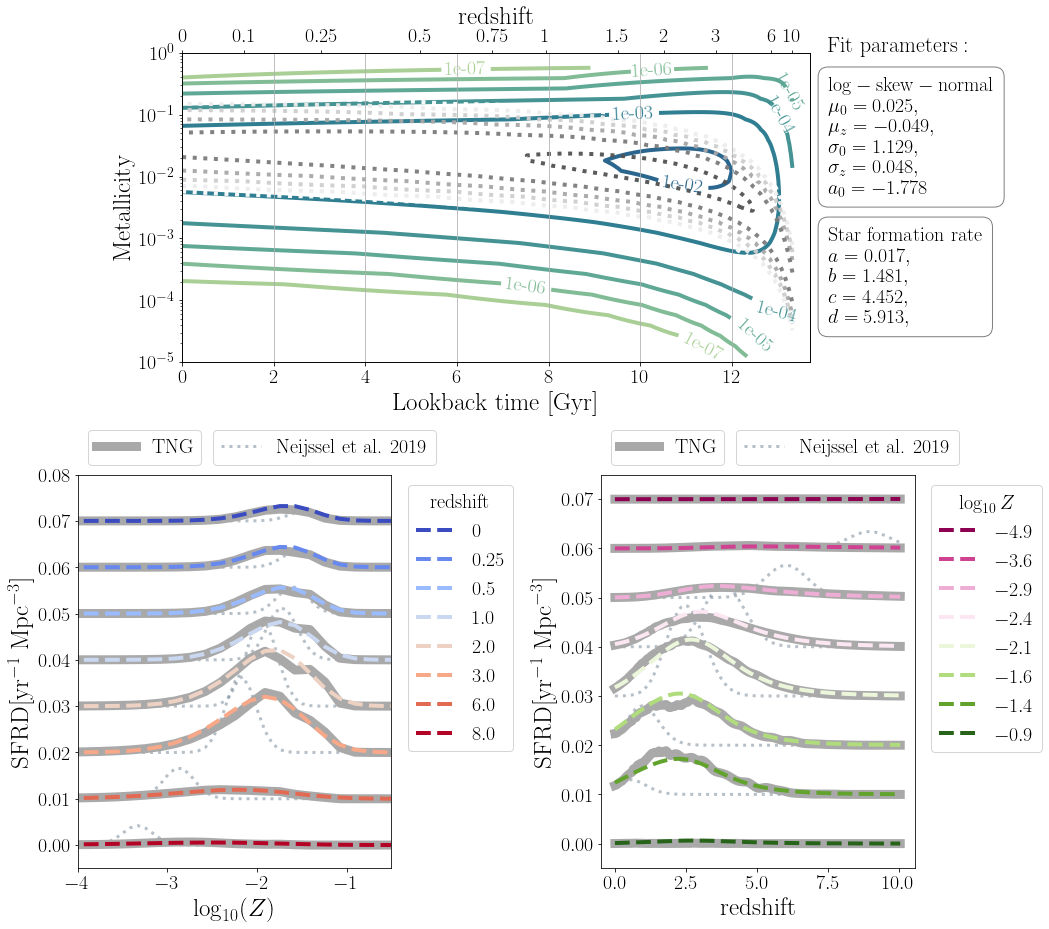

In [19]:
#####################################
# Get dPdZ 
# Make sure to calculate it at the same redshifts/metals as used in your fit
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu0=mu0_best, muz=muz_best,alpha_0 = alpha0_best, alpha_z = alphaz_best, 
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=ynew, redsh = z_new)#redshifts_TNG[::-1])
#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)
# Get the SFR
sfr = Madau_Dickinson2014(redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 
MSSFR = sfr*dPdlogZ.T
#####################################

fit_values_string = '$\mathrm{log-skew-normal}$'+'\n'+\
                    '$\mu_0=%s,$'%(np.round(mu0_best,3)) +'\n'+\
                    '$\mu_z=%s,$'%(np.round(muz_best,3)) +'\n'+\
                    '$\sigma_0=%s,$'%(np.round(sigma0_best,3)) +'\n'\
                    '$\sigma_z=%s,$'%(np.round(sigmaz_best,3)) +'\n'\
                    '$a_0=%s$'%(np.round(alpha0_best,3))

SFR_fit_string = '$\mathrm{Star \ formation \ rate}$'+'\n'+\
                 '$a=%s,$'%(np.round(sf_a_best,3)) +'\n'+\
                 '$b=%s,$'%(np.round(sf_b_best,3)) +'\n'+\
                 '$c=%s,$'%(np.round(sf_c_best,3)) +'\n'\
                 '$d=%s,$'%(np.round(sf_d_best,3))

Residuals_Zz_plane(obs_lookback = xnew, obs_metal = ynew, obs_SFRD = SFRDnew,
                   model_t = t_lookback.value, model_redshift=redshifts, model_y = metallicities, model_SFRD =MSSFR.value,
                   chi_square_matrix = chi_square_zZ,
                   scatter_residuals = False, add_TNG = False, 
                   plot_dPdZcontours = True, neijssel_fit = True,
                   COMPASkleur="crest", dPdZ_text = fit_values_string, SFR_text = SFR_fit_string)#light:k#404040 fe1100



# Variations on the metallicity distribution


0
Using interpolated TNG


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: Log scale: values of z <= 0 have been masked
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:139: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


saving here /Users/lieke/surfdrive/Documents/RateMassRedshiftEvolution//plots/SFRD_FIT_evaluation_compare_1.pdf


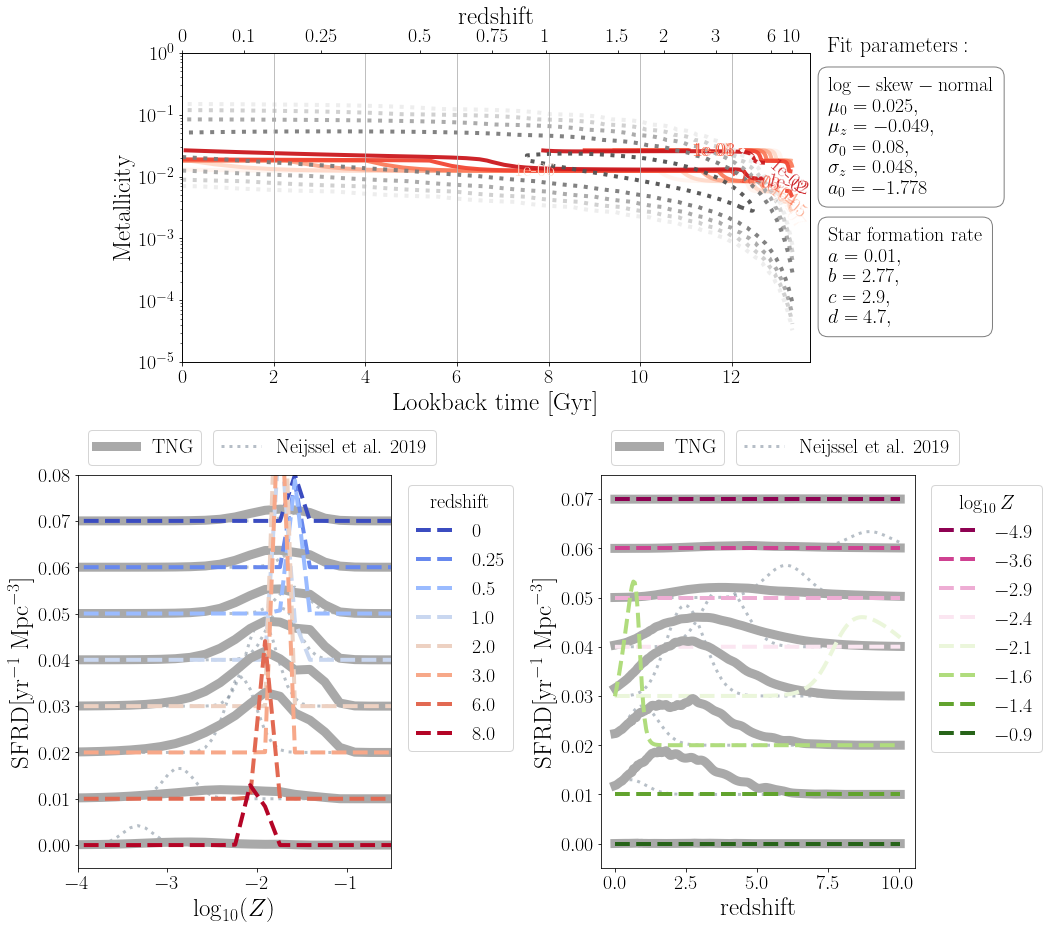

In [58]:
print( alphaz_best)

mu0_used     = mu0_best
muz_used     = muz_best
alpha_0_used = alpha0_best
sigma0_used  = 0.08#sigma0_best
sigma_z_used = sigmaz_best
#####################################
# Get dPdZ 
# Make sure to calculate it at the same redshifts/metals as used in your fit
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu0=mu0_used, muz=muz_used,alpha_0 = alpha_0_used, alpha_z = alphaz_best, 
                                              sigma_0=sigma0_used, sigma_z =sigma_z_used, min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=ynew, redsh = z_new)#redshifts_TNG[::-1])
#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)
# Get the SFR
          ## Madau ## Fid  ## Neijssel
a_used =  0.01 ## 0.01 ## 0.02 ## 0.01 #sf_a_best
b_used =  2.77 ## 2.6  ## 1.45 ## 2.77 #sf_b_best
c_used =  2.9  ## 3.2  ## 4.43 ## 2.9  #sf_c_best
d_used =  4.7  ## 6.2  ## 5.89 ## 4.7 #sf_d_best
sfr = Madau_Dickinson2014(redshifts, a=a_used, b=b_used, c=c_used,  d=d_used) # Msun year-1 Mpc-3 
MSSFR = sfr*dPdlogZ.T
#####################################

fit_values_string = '$\mathrm{log-skew-normal}$'+'\n'+\
                    '$\mu_0=%s,$'%(np.round(mu0_used,3)) +'\n'+\
                    '$\mu_z=%s,$'%(np.round(muz_used,3)) +'\n'+\
                    '$\sigma_0=%s,$'%(np.round(sigma0_used,3)) +'\n'\
                    '$\sigma_z=%s,$'%(np.round(sigma_z_used,3)) +'\n'\
                    '$a_0=%s$'%(np.round(alpha_0_used,3))

SFR_fit_string = '$\mathrm{Star \ formation \ rate}$'+'\n'+\
                 '$a=%s,$'%(np.round(a_used,3)) +'\n'+\
                 '$b=%s,$'%(np.round(b_used,3)) +'\n'+\
                 '$c=%s,$'%(np.round(c_used,3)) +'\n'\
                 '$d=%s,$'%(np.round(d_used,3))

Residuals_Zz_plane(obs_lookback = xnew, obs_metal = ynew, obs_SFRD = SFRDnew,
                   model_t = t_lookback.value, model_redshift=redshifts, model_y = metallicities, model_SFRD =MSSFR.value,
                   chi_square_matrix = chi_square_zZ,
                   scatter_residuals = False, add_TNG = False, 
                   plot_dPdZcontours = True, neijssel_fit = True,
                   COMPASkleur="Reds", dPdZ_text = fit_values_string, SFR_text = SFR_fit_string)#light:k#404040 fe1100



# MSSFR compared to TNG

In [27]:

def metal_contours_TNG(x = None, y = None, z = None, normed = False,
                                tmin = 0.0, tmax = 13.7, 
                                obs_redshift = [], obs_metal = [], obs_SFRD = [],
                                DCO= None, DCO_mask = None, W_i = None,
                                param1 = 'fWR', p1 = 1.0, param2 = 'coolWind', p2 =1.0,
                                redshift_list = np.linspace(0,10, num=100),
                                boundkleur = 'orange',COMPASkleur = 'Oranges', 
                                TNGkleur = 'YlGnBu', scatterKleur = 'RdYlGn_r', BBH_kleur = 'magma',
                                title = '', savestr ='fid',
                                min_logZ_COMPAS = np.log(1e-4),max_logZ_COMPAS = np.log(0.03),
                                add_TNG = True, plot_contours = True, scatter = False, BBHcontour=False,
                                show_boundaries = False, show_obs = False, fid_contours=False):
    '''
    x, y, z             ---------------> redshift/lookback time, metallicities, dP/dZ
    tmin,tmax           ---------------> min and max time in Gyr to show as xlim 
    DCO, DCO_mask       ---------------> table of double compact objects, + mask of which to include in plot 
    redshift_list       ---------------> redshifts to use for SFR
    kleur, kleurlabel   ---------------> colour/colour label of contour
    savestr             ---------------> string added to save name of plot
    min_logZ_COMPAS     ---------------> min ln(metal) that ocurs in COMPAS
    max_logZ_COMPAS     ---------------> max ln(metal) that ocurs in COMPAS
    '''
    # Create the Figure
    fig, ax = plt.subplots(figsize = (15,10))
    
    ##############################################################################

    ######################################
    if len(obs_SFRD) == 0:
        print('Using original TNG')
        with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
            MetalBins     = 10**f["MetalBins"][:]
            Lookbacktimes = f["Lookbacktimes"][:]
            BoxSfr        = f["Sfr"][:]

        # Take the centers of the metallicity bins
        center_Zbin = np.log10((MetalBins[:-1] + MetalBins[1:])/2. )

        # Convert SFR from sfr/box to sfr Mpc-3
        littleh = 0.6774
        Rbox    = 75/littleh
        cosmic_SFR = BoxSfr / Rbox**3 *u.Mpc**-3
        cosmic_SFR = cosmic_SFR.value
        cosmic_SFR = cosmic_SFR.T

    else:
        print('Using interpolated TNG')
        Lookbacktimes = obs_redshift
        center_Zbin   = obs_metal
        cosmic_SFR    = obs_SFRD
        
    if add_TNG:
        # construct cmap
        flatui = ['#ffe5b4','#ffc87c', '#ffb347', '#ed872d', '#ff9966','#ff8243',  '#eb7126']#
        #         tng_color = ListedColormap(sns.color_palette(flatui).as_hex())
        # construct smooth cmap from one colour
        tng_color_map = sns.light_palette("#fe875d", as_cmap=True)
        # Pick 7 colours from this smooth colourmap
        tng_colors   = tng_color_map(np.linspace(0.,1.0, 7) )
        # Turn it back into a cmap
        tng_color     = ListedColormap(tng_colors)


        TNG = ax.pcolormesh(Lookbacktimes, center_Zbin, cosmic_SFR, 
                            rasterized=True, norm=matplotlib.colors.LogNorm(vmin=1e-8,vmax=1e-1), 
                            cmap=tng_color, alpha=0.95 ) #matplotlib.cm.YlGnBu
        cbaxes1 = fig.add_axes([0.925, 0.1, 0.03, 0.8]) #[left, bottom, width, height],
        cb = plt.colorbar(TNG, cax = cbaxes1, label= r"$\mathrm{TNG \ SFRD \ [M_{\odot} yr^{-1} Mpc^{-3}]}$")  


    ##############################################################################
    # YOUR dP/dZ MODEL
    ##############################################################################
    if plot_contours:
        # Plot the contours of the metallicity density
        levels = [1e-7,1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e0]#np.logspace(2, 10., 10+1)
        COMPAS_cmap = sns.color_palette(COMPASkleur, as_cmap=True)
        
        cs = ax.contour(x, y, z, levels, linewidths=6.5, cmap=COMPAS_cmap,
                         locator=ticker.LogLocator(), alpha = 0.95, zorder=10)
        ax.clabel(cs,inline=1,fontsize=25, levels = levels, use_clabeltext=True, fmt = '%.0e')


    ##############################################################################
    # COMPA fiducial
    ##############################################################################
    if fid_contours:
        # Get dPdZ   
        fid_dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                        skew_metallicity_distribution(mu0=0.035, muz=-0.23,
                                                      alpha_0 = 0, alpha_z = 0, 
                                                      sigma_0=0.39, sigma_z =0, 
                                                      min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                                      metals=[], redsh = [])
        #Convert redshift to lookback time
        t_lookback = cosmo.lookback_time(redshifts)
        #####################################
        # Get the SFR Neijssel et al 2019: a=0.01, b=2.6, c=3.2,  d=6.2
        print(' sf_a_best=%s, sf_b_best=%s, sf_c_best=%s, sf_d_best=%s'%(sf_a_best, sf_b_best, sf_c_best, sf_d_best))
        fid_sfr = Madau_Dickinson2014(redshifts, a=0.01, b=2.77, c=2.9, d=4.7) # Msun year-1 Mpc-3 
        fid_MSSFR = fid_sfr*fid_dPdlogZ.T
        # Plot the contours of the metallicity density
        levels = [1e-7,1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e0]#np.logspace(2, 10., 10+1)
        fidCOMPAS_cmap = sns.color_palette("Blues", as_cmap=True)
        
        cs = ax.contour(t_lookback, metallicities, fid_MSSFR, levels, linewidths=3.5, cmap=fidCOMPAS_cmap,
                         locator=ticker.LogLocator(), alpha = 0.95, )
        ax.clabel(cs,inline=1,fontsize=25, levels = levels, use_clabeltext=True, fmt = '%.0e')

        
        
    ##############################################################################
    if show_boundaries:
        ######################################
        ## Show boundaries of COMPAS
        ax.hlines(np.e**min_logZ_COMPAS, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = boundkleur, lw = 4, ls = '-')
        ax.text(1.,np.e**min_logZ_COMPAS -4e-5, '$\mathrm{min \ Z \ simulated}$', color = boundkleur, size =25)

        ax.hlines(np.e**max_logZ_COMPAS, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = boundkleur, lw = 4, ls = '-')
        ax.text(1.,np.e**max_logZ_COMPAS+1e-2, '$\mathrm{max \ Z \ simulated}$', color = boundkleur, size =25)

    ##############################################################################
    if show_obs:
        obs_col = 'orange'
        ## Zsun
        ax.hlines(0.014*1.1, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, 0.014*1.1, '$Z=Z_{\odot}$', color = obs_col, va='bottom',size =25)

        ## LMC
        ax.hlines(0.014/2., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/2.)*1.1, '$\mathrm{LMC}$', color = obs_col, va='bottom', size =25)

        ## SMC
        ax.hlines(0.014/5., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/5.)*1.1, '$\mathrm{SMC}$', color = obs_col, va='bottom',size =25)

        ## Zw18
        ax.hlines(0.014/50., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/50.)*1.1, '$\mathrm{1 \ Zw \ 18}$', color = obs_col, va='bottom', size =25)
    ######################################
    # Scatter the mergning BBHs assuming they all merge at z = 0
    # from Myr to Gyr
    if scatter:
        DCO_mask = DCO_mask#*one_CE
        BBH = DCO[DCO_mask]
        Weight_mask = W_i > 1e-10
        print(len(BBH))
        scat = ax.scatter(BBH['tDelay'][Weight_mask]*1e-3, BBH['Metallicity@ZAMS(1)'][Weight_mask], 
                   label = 'COMPAS '+param1+str(p1)+param2+str(p2), s = W_i[Weight_mask]*300,
                   c=BBH['M_moreMassive'][Weight_mask], cmap = 'RdYlGn_r' ,vmin =2.5, vmax = 45)
        
        cbaxes1 = fig.add_axes([0.125, 0.0,0.8 , 0.02]) #[left, bottom, width, height],
        cb = plt.colorbar(scat, cax = cbaxes1, label='$M_{\mathrm{BH},1}$', orientation = 'horizontal')  
        #                facecolors='none', edgecolors=kleur) 
        ax.legend(loc ='lower left',markerscale=1)

    
#     ###################
#     #Plotvalues
    ax.xaxis.grid(5) # vertical lines
    ax.set_yscale('log')
    ax.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 35)
    ax.set_ylabel('$\mathrm{Metallicity}$', fontsize = 35)
    
    ######################################
    #### Add redshift Axis ####
    ax2 = ax.twiny()

    redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10]
    # Find loockback location for each of our ages
    z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]
    
    # And annotate the tick labels :)
    ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
    ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list],Fontsize = 20)
    ax2.set_xlabel('$\mathrm{redshift}$', fontsize = 35)

    #Make sure top and bottom axis are lined up (have same limmits)
    ax.set_xlim(tmin, tmax)
    ax2.set_xlim(tmin, tmax)
    
    ax.set_ylim(1e-5, 1e0)
    
    plt.title(title)
    print('saving here', save_loc + 'FIT_RedshiftMetal_Plane.pdf')
    plt.savefig(save_loc + 'FIT_RedshiftMetal_Plane.pdf',  bbox_inches='tight')
    
    plt.show()


# Show what our new fit looks like in the Z,z plane

/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


 sf_a_best=0.016579731761621523, sf_b_best=1.5079689886898067, sf_c_best=4.420068453108835, sf_d_best=5.8290212609177825
(202,) (29,) (29, 202)
Using interpolated TNG
 sf_a_best=0.016579731761621523, sf_b_best=1.5079689886898067, sf_c_best=4.420068453108835, sf_d_best=5.8290212609177825


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:181: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


saving here /Users/lieke/surfdrive/Documents/RateMassRedshiftEvolution//plots/FIT_RedshiftMetal_Plane.pdf


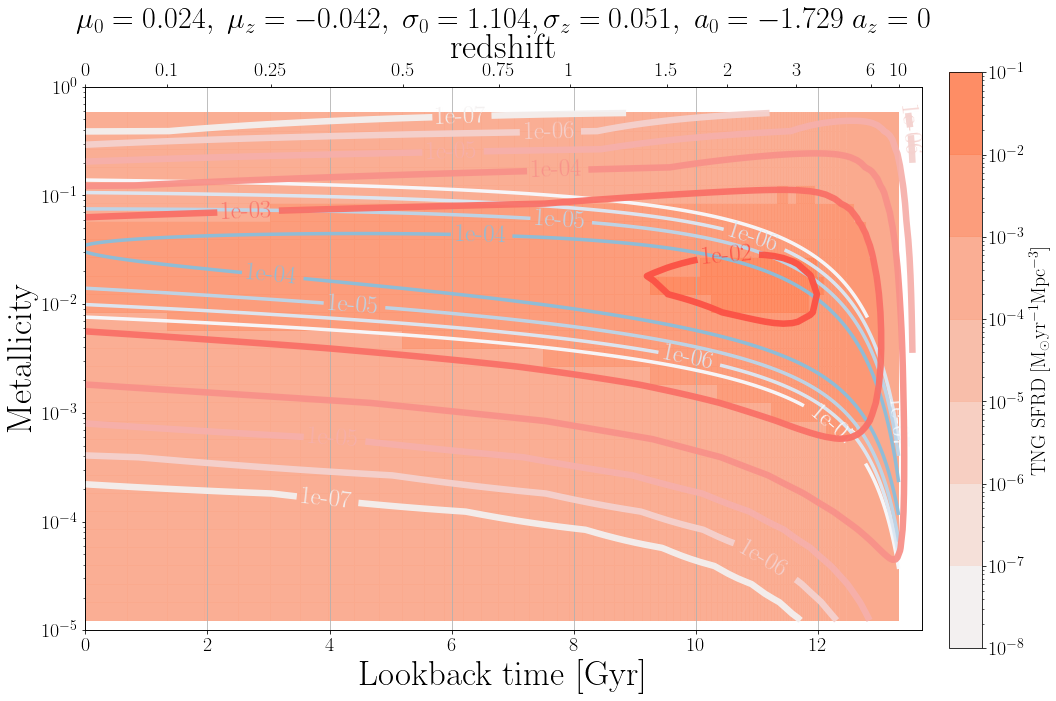

[ 0.          0.13658183  0.34030755  0.47534677  0.67671578  0.81015547
  1.00908311  1.14086723  1.33726997  1.46734342  1.66113951  1.85333323
  1.98055833  2.17001919  2.29539695  2.48204963  2.66698266  2.78930339
  2.97131465  3.15154078  3.27068859  3.50654754  3.62324616  3.79673883
  3.96834817  4.08169918  4.25012997  4.41663168  4.58118943  4.74378927
  4.90441867  5.06306637  5.21972221  5.37437747  5.52702452  5.72741947
  5.87535873  6.02127386  6.16516285  6.35386192  6.49302243  6.67542177
  6.80986482  6.98598935  7.11574095  7.28563467  7.45199472  7.61484448
  7.73469408  7.9301221   8.08261116  8.2317124   8.3774625   8.51990058
  8.69335341  8.82849234  8.99296052  9.15256312  9.30739418  9.5163257
  9.60313002  9.77192662  9.90779402 10.06523313 10.21673004 10.36246384
 10.52544101 10.68109903 10.82971687 10.97156926 11.12574783 11.27183568
 11.42698945 11.57291435 11.66532162 11.8666728  11.99903094 12.1225202
 12.27072847 12.34513494 12.44530365 12.52964511 12.6

In [91]:
######################################
# BEST FITTING PARAMETERS:
####################################################
# Get dPdZ   
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu0=mu0_best, muz=muz_best,
                                              alpha_0 = alpha0_best, alpha_z = alphaz_best, 
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=tofit_TNG_metals, redsh = redshifts_TNG[::-1])

#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)

#####################################
# Get the SFR
# Madau & Fragos 2017: a=0.01, b=2.6, c=3.2,  d=6.2
print(' sf_a_best=%s, sf_b_best=%s, sf_c_best=%s, sf_d_best=%s'%(sf_a_best, sf_b_best, sf_c_best, sf_d_best))
sfr = Madau_Dickinson2014(redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 


MSSFR = sfr*dPdlogZ.T
#/p_draw_metallicity # Msun year-1 Mpc-3 

color_pallette = sns.light_palette('#543884', as_cmap=True, n_colors= 2)#colormap[1]'#543884'


Title = '$\mu_0=%s, \ \mu_z=%s,  \ \sigma_0=%s, \sigma_z=%s, \ a_0=%s \ a_z=%s$'%(np.round(mu0_best,3),np.round(muz_best,3),\
                                                                       np.round(sigma0_best,3),np.round(sigmaz_best,3),\
                                                                       np.round(alpha0_best,3),np.round(alphaz_best,3) )

print(np.shape(xnew), np.shape(ynew), np.shape(SFRDnew))

# print(t_lookback,  metallicities, MSSFR.value)
metal_contours_TNG(x = t_lookback.value, y = metallicities, z =MSSFR.value, plot_contours = True,
                   obs_redshift = xnew, obs_metal = ynew, obs_SFRD = SFRDnew,
                   COMPASkleur="light:#fe1100", title = Title, fid_contours=True)

print(t_lookback, metallicities, np.amax(SFRDnew.T) )

# Test our newly found fit!




BEST FITTING PARAMETERS:
muz=-0.043903039483663794, mu0=0.023898696355024562, sigma_0 =1.2059153668930396, sigma_z =0.0390851425896455, alpha=-1.7671626767422142


Using interpolated TNG data
['0.00', '0.05', '0.10', '0.15', '0.20', '0.25', '0.30', '0.35', '0.40', '0.45', '0.50', '0.55', '0.60', '0.65', '0.70', '0.75', '0.80', '0.85', '0.90', '0.95', '1.00', '1.05', '1.10', '1.15', '1.20', '1.25', '1.30', '1.35', '1.40', '1.45', '1.50', '1.55', '1.60', '1.65', '1.70', '1.75', '1.80', '1.85', '1.90', '1.95', '2.00', '2.05', '2.10', '2.15', '2.20', '2.25', '2.30', '2.35', '2.40', '2.45', '2.50', '2.55', '2.60', '2.65', '2.70', '2.75', '2.80', '2.85', '2.90', '2.95', '3.00', '3.05', '3.10', '3.15', '3.20', '3.25', '3.30', '3.35', '3.40', '3.45', '3.50', '3.55', '3.60', '3.65', '3.70', '3.75', '3.80', '3.85', '3.90', '3.95', '4.00', '4.05', '4.10', '4.15', '4.20', '4.25', '4.30', '4.35', '4.40', '4.45', '4.50', '4.55', '4.60', '4.65', '4.70', '4.75', '4.80', '4.85', '4.90', '4.95', '5.00'

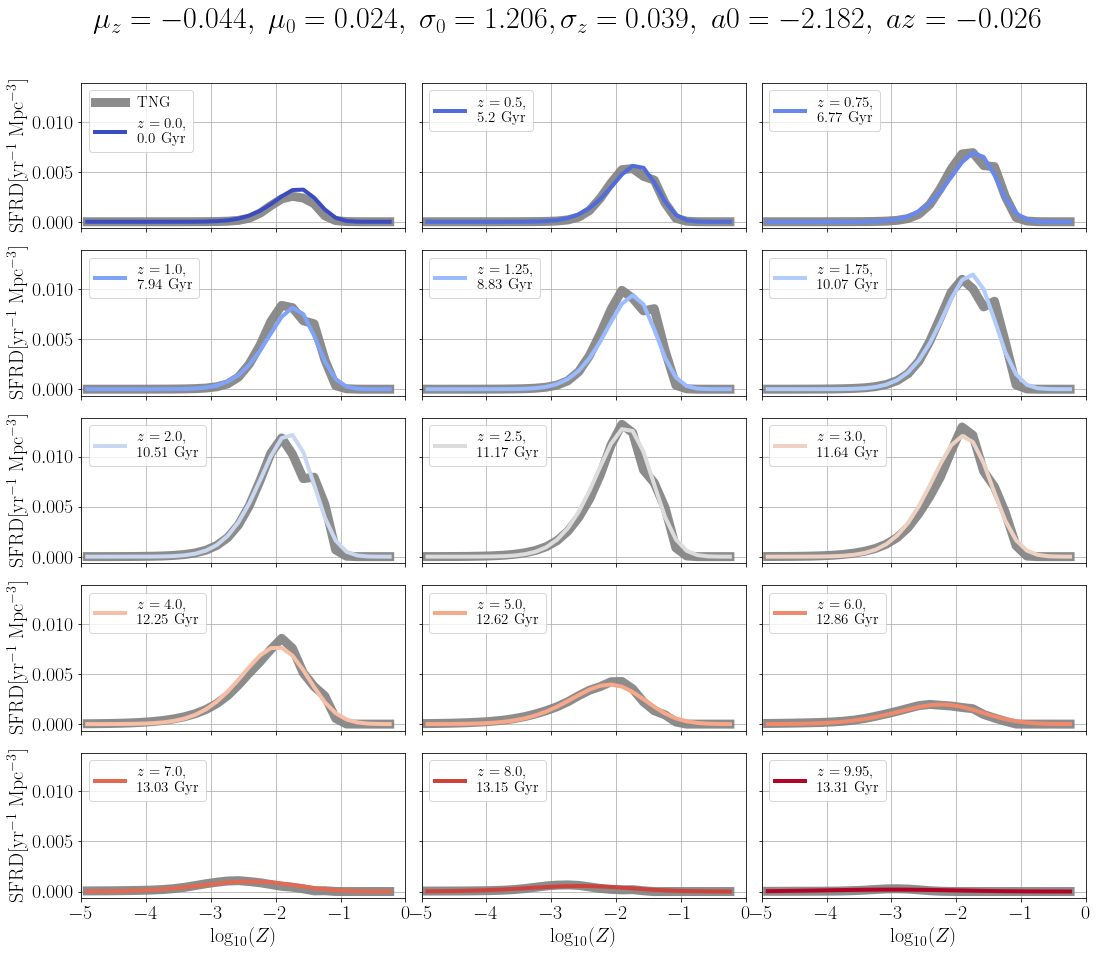

In [254]:

######################################
# BEST FITTING PARAMETERS:
print('\nBEST FITTING PARAMETERS:')
print('muz=%s, mu0=%s, sigma_0 =%s, sigma_z =%s, alpha=%s'% (muz_best, mu0_best, sigma0_best, sigmaz_best,alpha_best) )
print('\n')

######################################
normed = False
interpolated = True

######################################
if interpolated:
    # Use interpolated TNG
    print('Using interpolated TNG data')
    obs_redshift = z_new
    obs_metal = ynew
    obs_SFRD = SFRDnew.T
    redsfift_indces = [0,10,15,
                       20,25,35,
                       40,50,60,
                       80,100,120,
                       140,160,199]
else:
    # Use original TNG
    print('Using original TNG data')
    obs_redshift = redshifts_TNG[::-1]
    obs_metal = tofit_TNG_metals
    obs_SFRD = tofit_TNG_SFRD
    redsfift_indces = [0,8,15,32,40,48,58,60,66,70,75,80,88,91,95]


#####################################
# Get dPdZ   
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu0=mu0_best, muz=muz_best,
                                              alpha_0 = alpha0_best, alpha_z = alphaz_best, 
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=obs_metal, redsh = obs_redshift)
t_lookback = cosmo.lookback_time(redshifts)
print(['%.2f'% (z_fl) for  z_fl in redshifts ] )
##########
# Get the SFR
sfr = Madau_Dickinson2014(redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 

##########
colors     = plt.cm.coolwarm(np.linspace(0.,1.0, len(redsfift_indces))) #3rd num is the number of colours



######################################
# PLOT it!
# Draw the figure
#####################################
FIG, ax = plt.subplots(nrows=5,ncols=3, figsize=(18,15), squeeze=False, sharex=True, sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.15)#(20,28)

for z, redshift_i in enumerate(redsfift_indces):
    linestyles = ['-', ':', '--', '-.', ':']
    ######################################
    # "OBSERVATIONS" = TNG 
    ######################################
    row  = int(floor(z/3) )
    col  = z - row*3
    #print('row, col', row, col)
    
    if z == 0:
        LAB = "$\mathrm{TNG}$"
    else:
        LAB = None
    
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed: 
        obs_norm        = np.sum(obs_SFRD[redshift_i,:])
        normed_TNG_SFRD = obs_SFRD[redshift_i,:]/obs_norm
        ax[row,col].plot(np.log10(obs_metal), normed_TNG_SFRD, 
                         lw = 9, c = 'grey', alpha = 0.9,label = LAB)   
        
    # Plot the full fit, including params for SFR(z)
    else:
        ax[row,col].plot(np.log10(obs_metal), obs_SFRD[redshift_i,:] ,
                         lw = 9, c = 'grey', alpha = 0.9,label = LAB)    

    ######################################
    # MODEL = dPdlnZ * sfr(z)
    ######################################
    # Now the SFRD = sfr x dPdZ/p_draw_metallicity
    SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:] # Msun year-1 Mpc-3 

    ######################################
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed: 
        # model is normed in log space, so multiply by log binwidth
        model = dPdlogZ[redshift_i,:] *step_logZ 
        ax[row,col].plot(np.log10(metallicities), model, lw = 4, ls = linestyles[0], c = colors[z],
                 label = "$z=%s,$ \n$%s$ $\mathrm{Gyr}$"%(np.round(redshifts[redshift_i],2), np.round(t_lookback[redshift_i].value,2) ) )    
    
    # Plot the full fit, including params for SFR(z)
    else:
        print('sfr[redshift_i]',sfr[redshift_i])
        ax[row,col].plot(np.log10(metallicities), SFRD, lw = 4, ls = linestyles[0], c = colors[z],
             label = "$z=%s,$ \n$%s$ $\mathrm{Gyr}$"%(np.round(redshifts[redshift_i],2), np.round(t_lookback[redshift_i].value,2) ) )    

    ax[row,col].legend(fontsize = 15, loc='upper left')
    ax[row,col].grid()
    
    ax[row,col].set_xlim(-5, 0.)

# #########################################
#PlotValues
for x in ax.flat:
    x.set(xlabel='$\log_{10}(Z)$', ylabel='$\mathrm{SFRD [yr^{-1}\ Mpc^{-3}}$]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for x in ax.flat:
    x.label_outer()
    
title = '$\mu_z=%s, \ \mu_0=%s, \ \sigma_0=%s, \sigma_z=%s, \ a0=%s, \ az=%s$'%(np.round(muz_best,3),np.round(mu0_best,3),np.round(sigma0_best,3),np.round(sigmaz_best,3),np.round(alpha0_best,3), np.round(alphaz_best,3) )
plt.suptitle(title, y = 0.95)


print('saving here',save_loc + 'TNGfit_redshift_slices.pdf')
plt.savefig(save_loc + 'TNGfit_redshift_slices.pdf',  bbox_inches='tight')
    

plt.show()


# at fixed metallicity


BEST FITTING PARAMETERS:
muz =-0.043903039483663794, mu0 =0.023898696355024562, sigma0 =1.2059153668930396,sigmaz =0.0390851425896455, alpha=-1.7671626767422142


Using interpolated TNG data
obs_metal [-4.90872016 -4.7420535  -4.57538683 -4.40872016 -4.2420535  -4.07538683
 -3.90872016 -3.7420535  -3.57538683 -3.40872016 -3.2420535  -3.07538683
 -2.90872016 -2.7420535  -2.57538683 -2.40872016 -2.2420535  -2.07538683
 -1.90872016 -1.7420535  -1.57538683 -1.40872016 -1.2420535  -1.07538683
 -0.90872016 -0.7420535  -0.57538683 -0.40872016 -0.2420535 ]
(202,) (29,) (29, 202)
saving here /Users/lieke/surfdrive/Documents/RateMassRedshiftEvolution//plots/TNGfit_redshift_slices.pdf


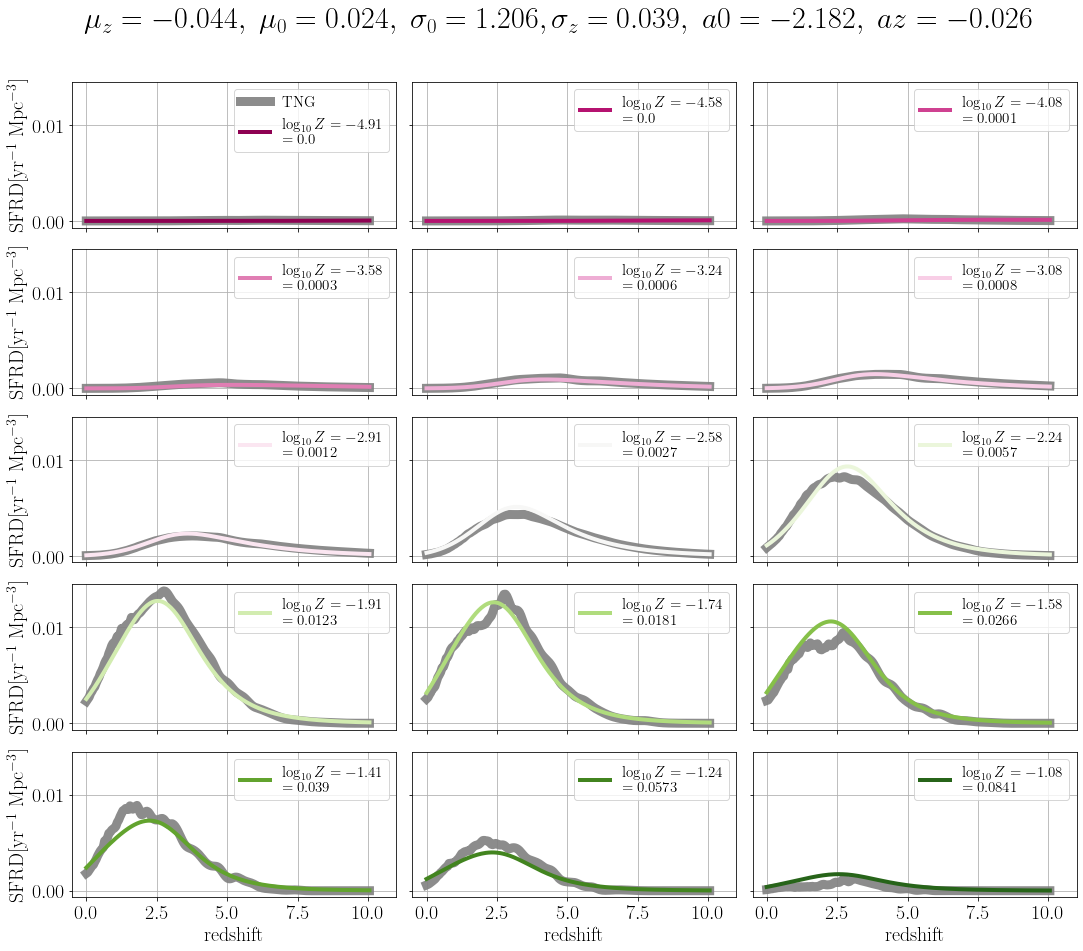

In [255]:

######################################
# BEST FITTING PARAMETERS:

print('\nBEST FITTING PARAMETERS:')
print('muz =%s, mu0 =%s, sigma0 =%s,sigmaz =%s, alpha=%s'% (muz_best,mu0_best,sigma0_best,sigmaz_best,alpha_best) )
print('\n')

######################################
normed       = False
interpolated = True

######################################
if interpolated:
    # Use interpolated TNG
    print('Using interpolated TNG data')
    obs_redshift = z_new
    obs_metal = ynew
    obs_SFRD = SFRDnew.T
    print('obs_metal' , np.log10(obs_metal) )
    print(np.shape(z_new), np.shape(ynew), np.shape(SFRDnew) )
#     metallicity_indces = [30, 32, 34, 36, 38, 40,42,44,46,48,50,52,54,56,58]
    metallicity_indces = [0,2,5,8,10,11,12,14,16,18,19,20,21,22,23]
    
else:
    # Use original TNG
    print('Using original TNG data')
    obs_redshift = redshifts_TNG[::-1]
    obs_metal = tofit_TNG_metals
    obs_SFRD = tofit_TNG_SFRD
    metallicity_indces = [0,2,5,8,10,11,12,14,16,18,19,20,21,22,23]

######################################
# Get dPdZ   
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu0=mu0_best, muz=muz_best,
                                              alpha_0 = alpha0_best, alpha_z = alphaz_best, 
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=obs_metal, redsh = obs_redshift)

#####################################
# Get the SFR
sfr = Madau_Dickinson2014(obs_redshift, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 


#####################################
colors     = plt.cm.PiYG(np.linspace(0.,1.0, len(metallicity_indces))) #3rd num is the number of colours

######################################
# PLOT it!
# Draw the figure
FIG, ax = plt.subplots(nrows=5,ncols=3, figsize=(18,15), squeeze=False, sharex=True, sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.15)#(20,28)

for Z, metal_i in enumerate(metallicity_indces):

    linestyles = ['-', ':', '--', '-.', ':']
    row  = int(floor(Z/3) )
    col  = Z - row*3
    #print('row, col', row, col)
    
    if Z == 0:
        LAB = "$\mathrm{TNG}$"
    else:
        LAB = None
    
    ######################################
    # "OBSERVATIONS" = TNG np.log10(
    ######################################
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed: 
        obs_norm        = np.sum(obs_SFRD[:,:], axis = -1)
        ax[row,col].plot(obs_redshift, obs_SFRD[:,metal_i]/obs_norm,
                         lw = 9, c = 'grey', alpha = 0.9,label = LAB) 
    # Plot the full fit, including params for SFR(z)
    else:
        ax[row,col].plot(obs_redshift, obs_SFRD[:,metal_i],
                         lw = 9, c = 'grey', alpha = 0.9,label = LAB) 
        
    ######################################
    # MODEL = dPdlnZ * sfr(z)
    ######################################
    # Now the SFRD = sfr x dPdZ/p_draw_metallicity
    SFRD = sfr *dPdlogZ[:, metal_i]# Msun year-1 Mpc-3 

    ######################################
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed: 
        # model is normed in log space, so multiply by log binwidth
        ax[row,col].plot(obs_redshift, dPdlogZ[:,metal_i] *step_logZ , lw = 4, ls = linestyles[0], c = colors[Z],
                 label = "$\log_{10}Z=%s$ \n $=%s$"%(np.round(np.log10(metallicities[metal_i]),2),np.round(metallicities[metal_i],4) ) )    
    else:
        ax[row,col].plot(obs_redshift, SFRD.value, lw = 4, ls = linestyles[0], c = colors[Z],
                 label = "$\log_{10}Z=%s$ \n $=%s$"%(np.round(np.log10(metallicities[metal_i]),2),np.round(metallicities[metal_i],4) ) )    
        
        
    ######################################
    # PLOT PARAMS
    ax[row,col].legend(fontsize = 15, loc='upper right')
    ax[row,col].grid()
    
    ax[row,col].set_xlim(-0.5, 11)
#     ax[row,col].set_ylim(0, 0.015)
#     ax[row,col].set_ylim(-10, -1)

# #########################################
#PlotValues
for x in ax.flat:
    x.set(xlabel='$\mathrm{redshift}$', ylabel='$\mathrm{SFRD [yr^{-1}\ Mpc^{-3}}$]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for x in ax.flat:
    x.label_outer()
    
title = '$\mu_z=%s, \ \mu_0=%s, \ \sigma_0=%s, \sigma_z=%s, \ a0=%s, \ az=%s$'%(np.round(muz_best,3),np.round(mu0_best,3),np.round(sigma0_best,3),np.round(sigmaz_best,3),np.round(alpha0_best,3), np.round(alphaz_best,3) )
plt.suptitle(title, y = 0.95)


print('saving here',save_loc + 'TNGfit_redshift_slices.pdf')
plt.savefig(save_loc + 'TNGfit_metal_slices.pdf',  bbox_inches='tight')

plt.show()


# Plot different realizations of the SFR(z)

max value 0.087390701185364 solMass / (Mpc3 yr)  at x_max =  11.406496746978968 Gyr


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in exp
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in multiply
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


saving here /Users/lieke/surfdrive/Documents/RateMassRedshiftEvolution//plots/SFR_tlookback.pdf


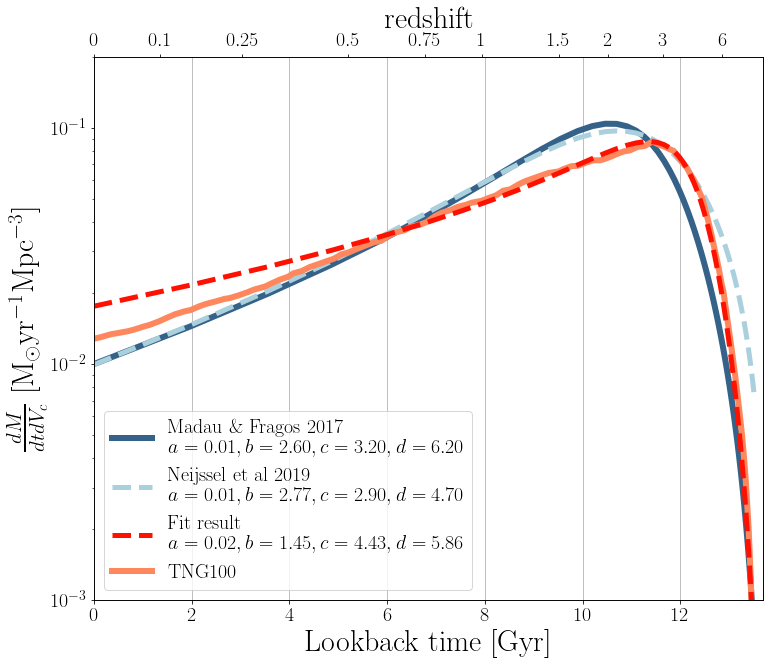

max value 0.087390701185364 solMass / (Mpc3 yr)  at x_max =  2.7272727272727275


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in exp
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in multiply
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


saving here /Users/lieke/surfdrive/Documents/RateMassRedshiftEvolution//plots/SFR_redshift.pdf


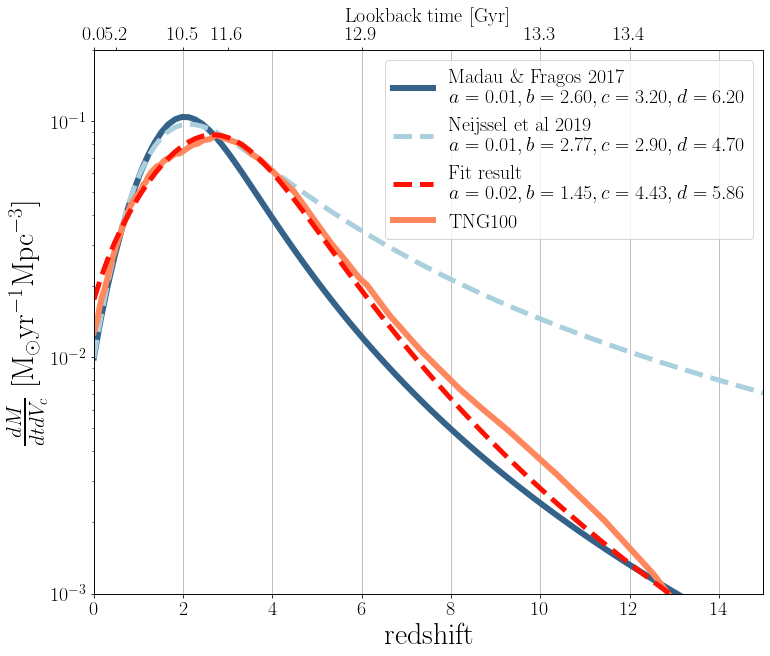

In [165]:

########################################################
# plot different SFRs
########################################################
def plot_SFR(redshift_list  = np.linspace(0,15, num=100), x_redshift = True, tmin=0.0, tmax = 13.7):
    ########################################################
    # Start plotting
    fig, ax = plt.subplots(figsize=(12,10))

    if x_redshift:
        x1  = redshift_list
    else:
        x1 = cosmo.lookback_time(redshift_list)


#     #default M&D 14
#     ax.plot(x1, Madau_Dickinson2014(redshift_list), 
#              label = 'Madau $\&$ Dickinson 2014\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.015,2.77,2.9,5.6)
#              , c = 'royalblue', ls = '--',lw=2)

    #default Madau & Fragos 17
    ax.plot(x1, Madau_Dickinson2014(redshift_list, a=0.01, b=2.6, c=3.2, d=6.2), 
             label = 'Madau $\&$ Fragos 2017\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.6,3.2,6.2)
             , c = '#356288', ls = '-',lw=6)

    #default Coen
    ax.plot(x1, Madau_Dickinson2014(redshift_list, a=0.01, b=2.77, c=2.9, d=4.7), 
             label = 'Neijssel et al 2019\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.77,2.9,4.7)
             , c = '#aacfdd', lw=5, ls = '--')


    # BEST FIT
    try:
        y_vals = Madau_Dickinson2014(redshift_list, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best)
        ax.plot(x1, y_vals,label = 'Fit result \n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (sf_a_best,sf_b_best,sf_c_best, sf_d_best), 
                 c = '#fe1100', lw=5, ls = '--', zorder =10)
        print('max value', y_vals[np.argmax(y_vals)], ' at x_max = ', x1[np.argmax(y_vals)])
    except:
        print('you probably havent run the optimzation yet..')



    ######################################
    # read TNG data
    ######################################
    with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
        MetalBins     = f["MetalBins"][:]
        Lookbacktimes = f["Lookbacktimes"][:]
        BoxSfr        = f["Sfr"][:]
    # Convert SFR from sfr/box to sfr Mpc-3
    littleh  = 0.6774
    Rbox     = 75/littleh
    TNG_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
    TNG_SFRD = TNG_SFRD.value
    # the last value of Lookbacktimes = 0, which is problematic for z calculation
    redshifts_TNG = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in Lookbacktimes[:-1]] 
    redshifts_TNG.append(0) # put redshift zero back at the end
    redshifts_TNG = np.array(redshifts_TNG)
    redshifts_TNG_inc = redshifts_TNG[::-1]
    ##########################################
    # "observed" TNG SFR(z)
    ##########################################
    if x_redshift:
        xobs  = redshifts_TNG
    else:
        xobs = Lookbacktimes

    ax.plot(xobs, np.sum(TNG_SFRD,axis=1), label = 'TNG100', c = '#fe875d', lw=6)

    ##########################################
    # Checking normalization of what I will fit
    ##########################################################################
    center_Zbin = (MetalBins[:-1] + MetalBins[1:])/2.
    sfr = Madau_Dickinson2014(redshifts_TNG_inc, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 
    # Get dPdZ 
    dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                    skew_metallicity_distribution(muz =-0.1, mu0 =0.025,
                                                  sigma_0=1.9,sigma_z=1.9, 
                                                  alpha_0 = -1.7, alpha_z = 0.,
                                                  metals=center_Zbin, redsh = redshifts_TNG_inc)
    if x_redshift:
        x  = redshifts
    else:
        x = cosmo.lookback_time(redshifts)

    # For each redshift in the TNG data:
    for redshift_i in range(len(redshifts)):
        SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:]#* step_logZ

    ##########################################################################
    #### Age Universe Axis ####
    ax2 = ax.twiny()

    if x_redshift:
        ###################
        #Plotvalues
        ax.set_xlabel('$\mathrm{redshift}$', fontsize = 30)

        # Find loockback location for each of our redshifts
        redshift_tick_list = [0, 0.5, 2, 3, 6, 10, 12]#[0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]
        # And annotate the tick labels :)
        ax2.set_xticks([z for z in redshift_tick_list])
        ax2.set_xticklabels(['${:.1f}$'.format(cosmo.lookback_time(z).value) for z in redshift_tick_list])
        ax2.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 20)

    else:
        ###################
        #Plotvalues
        ax.set_xlabel(r'$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 30)
        
        redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, ]
        # Find loockback location for each of our ages
        z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]

        # And annotate the tick labels :)
        ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
        ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
        ax2.set_xlabel('$\mathrm{redshift}$', fontsize = 30)


    ##########################################################################
    ax.xaxis.grid(5) # vertical lines
    # Make sure top and bottom axis are lined up (have same limmits)
    ax.set_xlim(tmin, tmax)
    ax2.set_xlim(tmin, tmax)
    logy = True
    if logy:
        plt.yscale('log')
    ax.set_ylabel(r'$\frac{dM}{dt dV_c}$ $\mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$', fontsize = 30)
    ax.set_ylim(1e-3, 0.2)
    ax.legend()
    if x_redshift:
        print('saving here', save_loc + 'SFR_redshift'+'.pdf')
        plt.savefig(save_loc + 'SFR_redshift'+'.pdf',  bbox_inches='tight')
    else:
        print('saving here', save_loc + 'SFR_tlookback'+'.pdf')
        plt.savefig(save_loc + 'SFR_tlookback'+'.pdf',  bbox_inches='tight')
    
    plt.show()

    
# time axis
plot_SFR(redshift_list  = np.linspace(0,15, num=100), x_redshift = False, tmin=0.0, tmax = 13.7)

# redshift axis
plot_SFR(redshift_list  = np.linspace(0,15, num=100), x_redshift = True, tmin=0.0, tmax = 15)


# Same but in redshift space

In [170]:
                         
def metal_contours_TNG_zspace(x = None, y = None, z = None, normed = False,
                                tmin = 0.0, tmax = 13.7,
                              obs_redshift = [], obs_metal = [], obs_SFRD = [],
                                DCO= None, DCO_mask = None, W_i = None,
                                param1 = 'fWR', p1 = 1.0, param2 = 'coolWind', p2 =1.0,
                                redshift_list = np.linspace(0,10, num=100),
                                boundkleur = 'orange',COMPASkleur = 'Oranges', 
                                TNGkleur = 'YlGnBu', scatterKleur = 'RdYlGn_r', BBH_kleur = 'magma',
                                title = '', savestr ='fid',
                                min_logZ_COMPAS = np.log(1e-4),max_logZ_COMPAS = np.log(0.03),
                                add_TNG = True, plot_contours = True, scatter = False, BBHcontour=False,
                                show_boundaries = False, show_obs = False):
    '''
    x, y, z             ---------------> redshift/lookback time, metallicities, dP/dZ
    tmin,tmax           ---------------> min and max time in Gyr to show as xlim 
    DCO, DCO_mask       ---------------> table of double compact objects, + mask of which to include in plot 
    redshift_list       ---------------> redshifts to use for SFR
    kleur, kleurlabel   ---------------> colour/colour label of contour
    savestr             ---------------> string added to save name of plot
    min_logZ_COMPAS     ---------------> min ln(metal) that ocurs in COMPAS
    max_logZ_COMPAS     ---------------> max ln(metal) that ocurs in COMPAS
    '''
    ######################################
    # Create the Figure
    fig, ax = plt.subplots(figsize = (20,16))
    
    ##############################################################################
    if add_TNG:
        ######################################
        if len(obs_SFRD) == 0:
            print('Using original TNG')
            with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
                MetalBins     = 10**f["MetalBins"][:]
                Lookbacktimes = f["Lookbacktimes"][:]
                BoxSfr        = f["Sfr"][:]

            # Take the centers of the metallicity bins
            center_Zbin = np.log10(np.log10((MetalBins[:-1] + MetalBins[1:])/2. ) )

            # Convert SFR from sfr/box to sfr Mpc-3
            littleh = 0.6774
            Rbox    = 75/littleh
            cosmic_SFR = BoxSfr / Rbox**3 *u.Mpc**-3
            cosmic_SFR = cosmic_SFR.value
            cosmic_SFR = cosmic_SFR.T
            
            #### TNG redshifts corresponding to these lookback times ### 
            # the last value of Lookbacktimes = 0, which is problematic for z calculation
            redshifts_TNG = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in Lookbacktimes[:-1]] 
            redshifts_TNG.append(0) # put redshift zero back at the end
            redshifts_TNG = np.array(redshifts_TNG)        

        else: 
            print('Using interpolated TNG')
            redshifts_TNG = obs_redshift
            center_Zbin   = obs_metal
            cosmic_SFR    = obs_SFRD    
            ax.set_yscale('log')
            
            
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed:
        norm_cosmic_SFR = np.sum(cosmic_SFR, axis = -1)
        cosmic_SFR = cosmic_SFR/norm_cosmic_SFR[:,np.newaxis]  
    
    # construct cmap
    flatui = ['#ffe5b4','#ffc87c', '#ffb347', '#ed872d', '#ff9966','#ff8243',  '#eb7126']#
    #         tng_color = ListedColormap(sns.color_palette(flatui).as_hex())
    # construct smooth cmap from one colour
    tng_color_map = sns.light_palette("#fe875d", as_cmap=True)
    # Pick 7 colours from this smooth colourmap
    tng_colors   = tng_color_map(np.linspace(0.,1.0, 7) )
    # Turn it back into a cmap
    tng_color     = ListedColormap(tng_colors)

    if add_TNG:
        TNG = ax.pcolormesh(redshifts_TNG, center_Zbin, cosmic_SFR, 
                            rasterized=True, norm=matplotlib.colors.LogNorm(vmin=1e-8,vmax=1e-1), 
                            cmap=tng_color, alpha=0.95 ) #matplotlib.cm.YlGnBu
        cbaxes1 = fig.add_axes([0.925, 0.1, 0.03, 0.8]) #[left, bottom, width, height],
        cb = plt.colorbar(TNG, cax = cbaxes1, label= r"$\mathrm{TNG \ SFRD \ [M_{\odot} yr^{-1} Mpc^{-3}]}$")  


    ##############################################################################
    if plot_contours:
        # Plot the contours of the metallicity density
        levels = [1e-7,1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e0]#np.logspace(2, 10., 10+1)
        COMPAS_cmap = sns.color_palette(COMPASkleur, as_cmap=True)

        cs = ax.contour(x, y, z, levels, linewidths=6.5, cmap=COMPAS_cmap)
#                          locator=ticker.LogLocator(), alpha = 0.95, )
        ax.clabel(cs,inline=1,fontsize=25, levels = levels, use_clabeltext=True, fmt = '%.0e')


    ##############################################################################
    if show_boundaries:
        ######################################
        ## Show boundaries of COMPAS
        ax.hlines(np.e**min_logZ_COMPAS, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = boundkleur, lw = 4, ls = '-')
        ax.text(1.,np.e**min_logZ_COMPAS -4e-5, '$\mathrm{min \ Z \ simulated}$', color = boundkleur, size =25)

        ax.hlines(np.e**max_logZ_COMPAS, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = boundkleur, lw = 4, ls = '-')
        ax.text(1.,np.e**max_logZ_COMPAS+1e-2, '$\mathrm{max \ Z \ simulated}$', color = boundkleur, size =25)

    ##############################################################################
    if show_obs:
        obs_col = 'orange'
        ## Zsun
        ax.hlines(0.014*1.1, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, 0.014*1.1, '$Z=Z_{\odot}$', color = obs_col, va='bottom',size =25)

        ## LMC
        ax.hlines(0.014/2., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/2.)*1.1, '$\mathrm{LMC}$', color = obs_col, va='bottom', size =25)

        ## SMC
        ax.hlines(0.014/5., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/5.)*1.1, '$\mathrm{SMC}$', color = obs_col, va='bottom',size =25)

        ## Zw18
        ax.hlines(0.014/50., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/50.)*1.1, '$\mathrm{1 \ Zw \ 18}$', color = obs_col, va='bottom', size =25)
    
    ######################################
    # Scatter the mergning BBHs assuming they all merge at z = 0
    # from Myr to Gyr
    if scatter:
        DCO_mask = DCO_mask#*one_CE
        BBH = DCO[DCO_mask]
        Weight_mask = W_i > 1e-10
        print(len(BBH))
        scat = ax.scatter(BBH['tDelay'][Weight_mask]*1e-3, BBH['Metallicity@ZAMS(1)'][Weight_mask], 
                   label = 'COMPAS '+param1+str(p1)+param2+str(p2), s = W_i[Weight_mask]*300,
                   c=BBH['M_moreMassive'][Weight_mask], cmap = 'RdYlGn_r' ,vmin =2.5, vmax = 45)
        
        cbaxes1 = fig.add_axes([0.125, 0.0,0.8 , 0.02]) #[left, bottom, width, height],
        cb = plt.colorbar(scat, cax = cbaxes1, label='$M_{\mathrm{BH},1}$', orientation = 'horizontal')  
        #                facecolors='none', edgecolors=kleur) 
        ax.legend(loc ='lower left',markerscale=1)

    
    ###################
    #Plotvalues
    ax.xaxis.grid(5) # vertical lines
    ax.set_xlabel('$\mathrm{redshift}$', fontsize = 40)
    ax.set_ylabel('$\mathrm{Metallicity}$', fontsize = 40)
    ax.set_yscale('log')
    
    ######################################
    #### Add redshift Axis ####
    ax2 = ax.twiny()

    # Find loockback location for each of our redshifts
    redshift_tick_list = [0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]
    # And annotate the tick labels :)
    ax2.set_xticks([z for z in redshift_tick_list])
    ax2.set_xticklabels(['${:.1f}$'.format(cosmo.lookback_time(z).value) for z in redshift_tick_list])
    ax2.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 20)

    #Make sure top and bottom axis are lined up (have same limmits)
    ax.set_xlim(tmin, tmax)
    ax2.set_xlim(tmin, tmax)
    
    ax.set_ylim(1e-5, 1e0)
#     ax.set_ylim(-5, 0)
    
    plt.title(title)
    print('saving here', save_loc + 'RedshiftMetal_Plane'+savestr+'.pdf')
#     plt.savefig(save_loc + 'RedshiftMetal_Plane'+savestr+'.jpg',  bbox_inches='tight')
    
    plt.show()

    




Using interpolated TNG
saving here /Users/lieke/surfdrive/Documents/RateMassRedshiftEvolution//plots/RedshiftMetal_Planefid.pdf


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


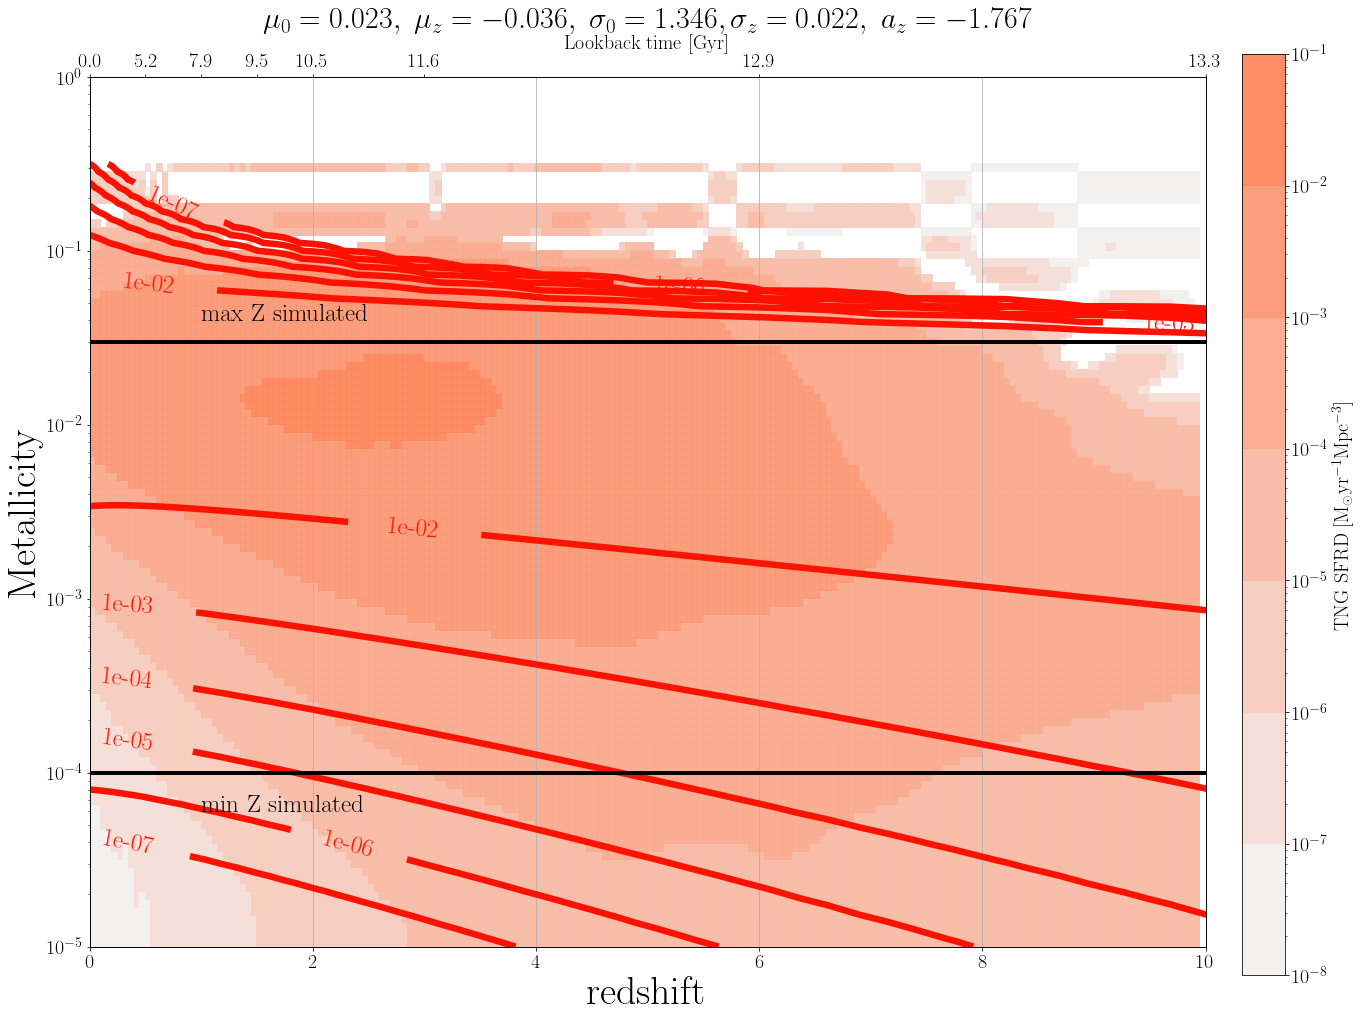

In [173]:
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu0=mu0_best, muz=muz_best,
                                              alpha_0 = alpha0_best, alpha_z = alpha0_best,
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=ynew, redsh = redshifts_TNG[::-1])
# and the SFR
sfr = Madau_Dickinson2014(redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 

#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)


#####################################
MSSFR = dPdlogZ.T #*sfr
# MSSFR = MSSFR.value
#/p_draw_metallicity # Msun year-1 Mpc-3 

#####
color_pallette = sns.light_palette('#543884', as_cmap=True, n_colors= 2)#colormap[1]'#543884'
Title = '$\mu_0=%s, \ \mu_z=%s,  \ \sigma_0=%s, \sigma_z=%s, \ a_z=%s$'%(np.round(mu0_best,3),np.round(muz_best,3), np.round(sigma0_best,3),np.round(sigmaz_best,3),np.round(alpha_best,3) )

metal_contours_TNG_zspace(x = redshifts, y = metallicities, z = MSSFR, 
                          add_TNG=True, plot_contours = True, scatter = False, 
                          show_boundaries = True, boundkleur = 'k',
                          BBHcontour=False,show_obs = False,
                          title = Title, tmin = 0.0, tmax = 10.,COMPASkleur = 'light:#fe1100_r', 
                          obs_redshift = z_new, obs_metal = ynew, obs_SFRD = SFRDnew,normed = False)
